# 🎬 C1n3mada presents: Money, Money, Movies – The secrets of movies’ box office success 🎥

## Movie 1: Echo 📢 How does a movie’s IMDb rating relate to its box office success?

The film industry is a complex ecosystem where various factors contribute to a movie’s success. Among these factors, audience reception and financial performance are two critical metrics. This analysis aims to explore the relationship between a movie’s IMDb rating—a reflection of audience and critic reception—and its box office revenue. Understanding this relationship can provide valuable insights for filmmakers, producers, investors as well as researchers such as us.

Research Question: How does a movie’s IMDb rating relate to its box office success? Is the rating coherent with the movie’s financial success?

### Data Loading and Preprocessing

Importing Libraries

In [94]:
import ast
import warnings
from collections import Counter
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import clear_output
from ipywidgets import interact, widgets
from scipy import stats
from scipy.stats import f_oneway, pearsonr, spearmanr
from statsmodels.formula.api import ols
from tabulate import tabulate

from src.utils.plot_utils import revenue_formatter

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline
# auto-reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading the Dataset

In [95]:
# load the dataset
PATH = "data/processed/movies_processed.csv"
df = pd.read_csv(PATH)

df.head()

wiki_movie_id freebase_movie_id                movie_name  \
0         975900         /m/03vyhn            Ghosts of Mars   
1       10408933        /m/02qc0j7  Alexander's Ragtime Band   
2         171005         /m/016ywb                   Henry V   
3          77856          /m/0kcn7              Mary Poppins   
4         612710         /m/02wjqm            New Rose Hotel   

  movie_release_date  movie_box_office_revenue  movie_runtime  \
0         2001-08-24                14010832.0           98.0   
1         1938-08-16                 3600000.0          106.0   
2         1989-11-08                10161099.0          137.0   
3         1964-08-27               102272727.0          139.0   
4         1999-10-01                   21521.0           92.0   

                        movie_languages  \
0  [('/m/02h40lc', 'English Language')]   
1  [('/m/02h40lc', 'English Language')]   
2  [('/m/02h40lc', 'English Language')]   
3  [('/m/02h40lc', 'English Language')]   
4  [('/m/02h40lc', 'English Language')]   

                               movie_countries  \
0  [('/m/09c7w0', 'United States of America')]   
1  [('/m/09c7w0', 'United States of America')]   
2             [('/m/07ssc', 'United Kingdom')]   
3  [('/m/09c7w0', 'United States of America')]   
4  [('/m/09c7w0', 'United States of America')]   

                                        movie_genres  release_year  ...  \
0  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...        2001.0  ...   
1  [('/m/04t36', 'Musical'), ('/m/01z4y', 'Comedy...        1938.0  ...   
2  [('/m/04xvh5', 'Costume drama'), ('/m/082gq', ...        1989.0  ...   
3  [('/m/0hj3myq', "Children's/Family"), ('/m/04t...        1964.0  ...   
4  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...        1999.0  ...   

     imdb_id  combined_revenue release_month  release_day  \
0  tt0228333        14010832.0           8.0         24.0   
1  tt0029852         4000000.0           8.0         16.0   
2  tt0097499        10161099.0          11.0          8.0   
3  tt0058331       102272727.0           8.0         27.0   
4        NaN           21521.0          10.0          1.0   

               primaryTitle  startYear averageRating  numVotes  \
0            Ghosts of Mars     2001.0           4.9   58868.0   
1  Alexander's Ragtime Band     1938.0           6.8    2357.0   
2                   Henry V     1989.0           7.5   32088.0   
3              Mary Poppins     1964.0           7.8  189183.0   
4                       NaN        NaN           0.0       0.0   

           director  inflated_revenue  
0    John Carpenter      1.899115e+07  
1        Henry King      6.812740e+07  
2   Kenneth Branagh      1.967252e+07  
3  Robert Stevenson      7.913870e+08  
4           Unknown      3.100822e+04  

[5 rows x 22 columns]

#### Selecting Relevant Columns
For this analysis, we’ll focus on the following columns:
*	averageRating: The IMDb rating of the movie.
*	inflated_revenue: The box office revenue adjusted for inflation.
*	numVotes: The number of votes the movie received on IMDb.
*   movie_genres: The genres of the movie.

In [96]:
# Select relevant columns
df_rating = df[
    ["movie_name", "averageRating", "inflated_revenue", "numVotes", "movie_genres"]
]

#### Handling Missing Values
We’ll check and remove the rows that contains no votes or revenue information.

In [97]:
# Drop rows with missing values or zero numVotes
df_rating.dropna(
    subset=["averageRating", "inflated_revenue", "numVotes"],
    inplace=True,
)
df_rating = df_rating[df_rating.numVotes > 0]

/tmp/ipykernel_381043/4034868418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rating.dropna(


#### Handling Duplicates

In [98]:
# Check for duplicates
df_rating.duplicated().sum()

# remove duplicates if any
df_rating.drop_duplicates(inplace=True)

In [99]:
# Split genres into a list of genres names
df_rating["genres_list"] = df_rating["movie_genres"].apply(
    lambda x: [genre[1] for genre in eval(x)]
)

### Exploratory Data Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>


  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

</div>

#### Summary Statistics

In [100]:
df_rating.describe()

averageRating  inflated_revenue      numVotes
count    7935.000000      7.935000e+03  7.935000e+03
mean        6.429931      8.483343e+07  7.854191e+04
std         0.969471      2.060112e+08  1.774744e+05
min         1.600000      1.355462e+00  7.400000e+01
25%         5.900000      6.352539e+06  5.690500e+03
50%         6.500000      2.494240e+07  2.008900e+04
75%         7.100000      8.024377e+07  7.243900e+04
max         9.300000      6.905588e+09  2.959489e+06

#### Number of Movies per Genre

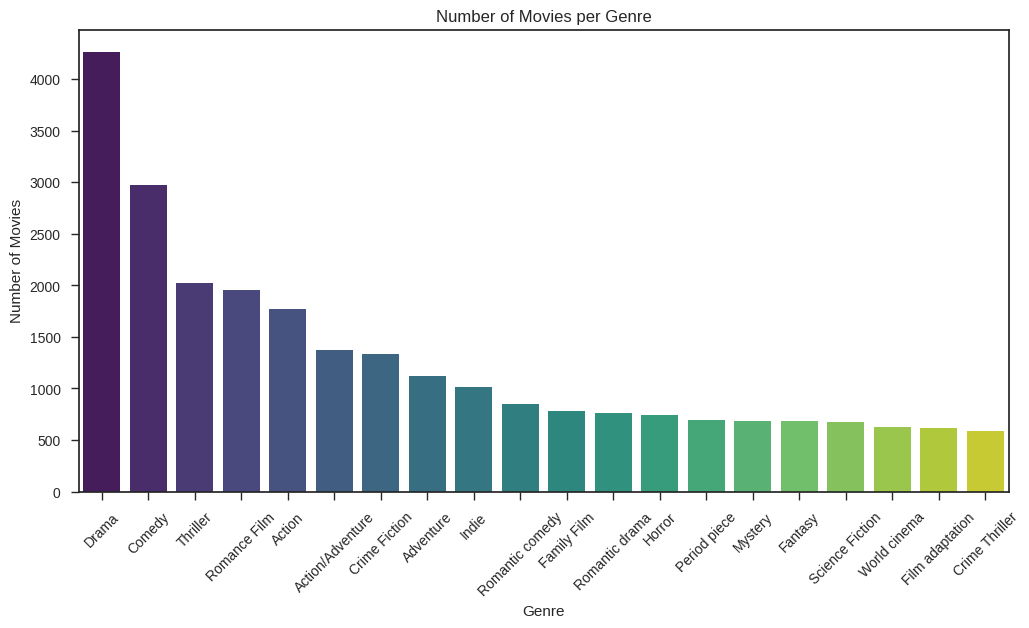

In [101]:
# Explode the genres_list to count each genre separately
genre_counts = df_rating.explode("genres_list")["genres_list"].value_counts()

# get the most common 20 genres
genre_counts_top20 = genre_counts.head(20)


plt.figure(figsize=(12, 6))
sns.barplot(
    x=genre_counts_top20.index,
    y=genre_counts_top20.values,
    palette="viridis",
    hue=genre_counts_top20.index,
)
plt.title("Number of Movies per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()

#### Distribution of IMDb Ratings

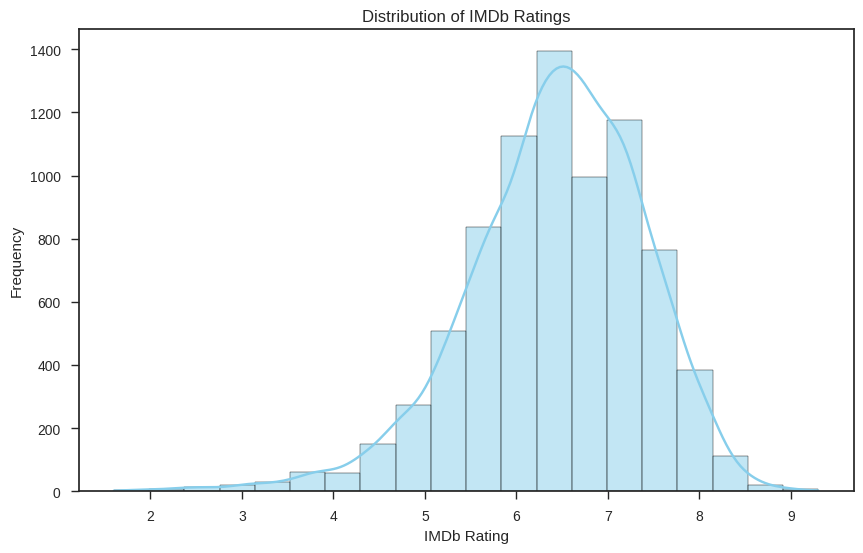

In [102]:
plt.figure(figsize=(10, 6))
sns.histplot(df_rating["averageRating"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of IMDb Ratings")
plt.xlabel("IMDb Rating")
plt.ylabel("Frequency")
plt.show()

#### Distribution of Box Office Revenue
Due to the wide range of revenues, we’ll use a logarithmic scale.

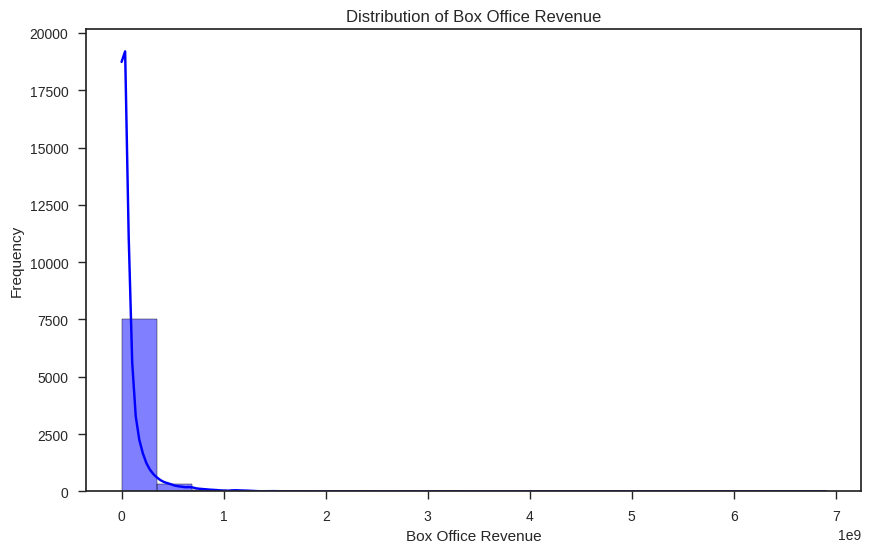

In [189]:
plt.figure(figsize=(10, 6))
sns.histplot(df_rating["inflated_revenue"], bins=20, kde=True, color="blue")
plt.title("Distribution of Box Office Revenue")
plt.xlabel("Box Office Revenue")
plt.ylabel("Frequency")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - For our analysis, we log-transformed the movie revenue data (using log base 10) for several reasons:
  - **Distribution Properties**: As we can see from the Distribution of the Box Office Revenue plot above, movie revenues show a right-skewed distribution with a long tail of high-revenue outliers. Log transformation helps normalize this distribution.
  - **Statistical Considerations**: The transformation helps meet OLS regression assumptions by:
    - Making the relationship more linear
    - Normalizing the distribution of errors

</div>

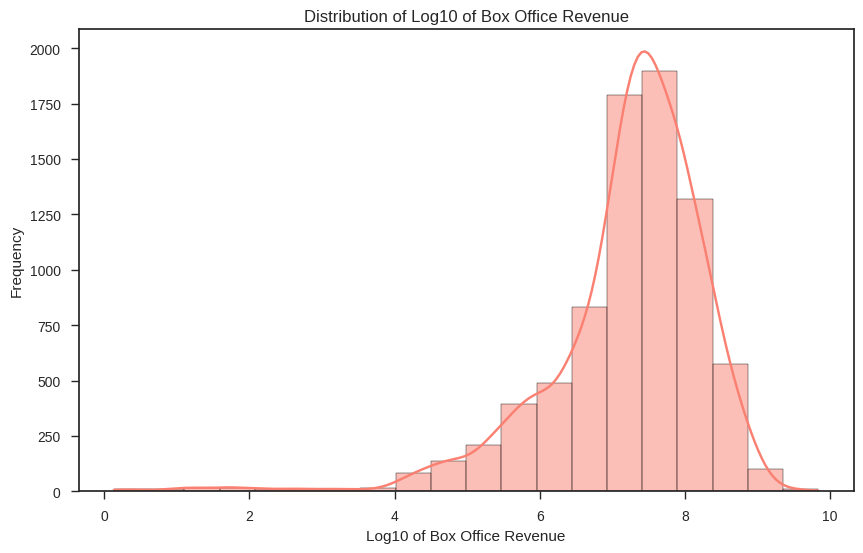

In [104]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log10(df_rating["inflated_revenue"]), bins=20, kde=True, color="salmon")
plt.title("Distribution of Log10 of Box Office Revenue")
plt.xlabel("Log10 of Box Office Revenue")
plt.ylabel("Frequency")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - As shown in the plots above, the log transformation provides a more normally distributed dependent variable.

</div>

#### Scatter Plot of IMDb Ratings vs. Box Office Revenue

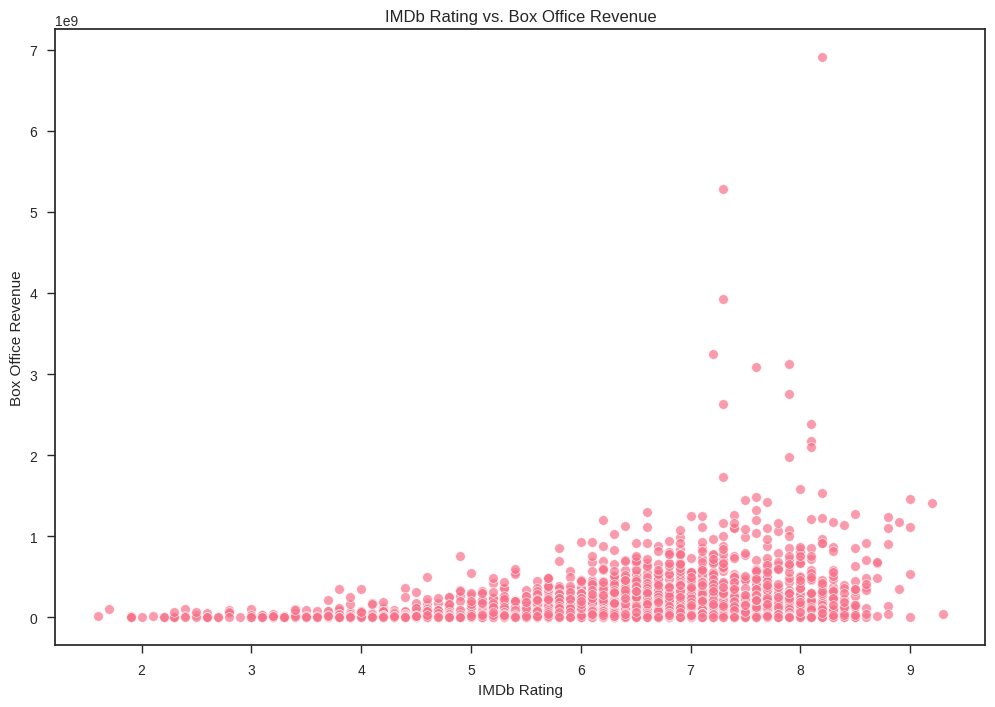

In [105]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="averageRating", y="inflated_revenue", data=df_rating, alpha=0.7)
plt.title("IMDb Rating vs. Box Office Revenue")
plt.xlabel("IMDb Rating")
plt.ylabel("Box Office Revenue")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The scatter plot shows a lot of dispersion. To better visualize the data, we’ll apply a logarithmic transformation to the revenue.

</div>

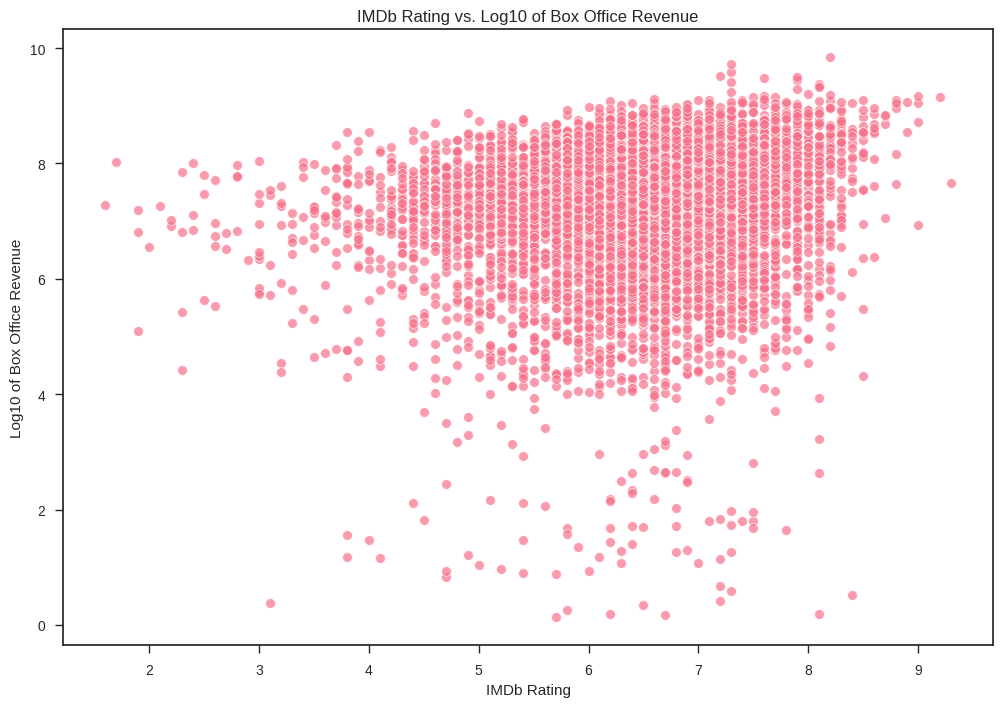

In [106]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="averageRating",
    y=np.log10(df_rating["inflated_revenue"]),
    data=df_rating,
    alpha=0.7,
)
plt.title("IMDb Rating vs. Log10 of Box Office Revenue")
plt.xlabel("IMDb Rating")
plt.ylabel("Log10 of Box Office Revenue")
plt.show()

#### Joint Distruibution Plot (IMDb Ratings vs Box Office Revenue)
Said's Note: We may omit this part as more sophisticated visualization is added at the end of the notebook.

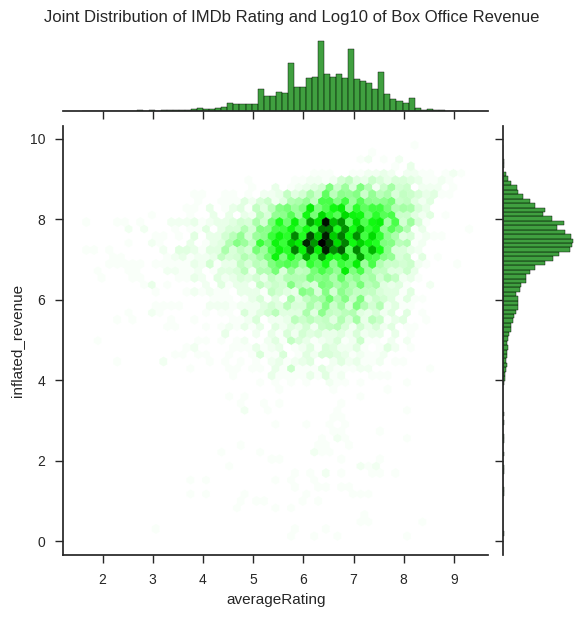

In [107]:
sns.jointplot(
    x="averageRating",
    y=np.log10(df_rating["inflated_revenue"]),
    data=df_rating,
    kind="hex",
    color="green",
)
plt.suptitle(
    "Joint Distribution of IMDb Rating and Log10 of Box Office Revenue", y=1.02
)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

</div>

### Correlation Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>
  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  
</div>

#### Calculating the Correlation Coefficient

In [108]:
# Pearson correlation
corr_pearson = df_rating[["averageRating", "inflated_revenue"]].corr(method="pearson")
print("Pearson Correlation Coefficient:")
print(corr_pearson)

# Spearman correlation
corr_spearman = df_rating[["averageRating", "inflated_revenue"]].corr(method="spearman")
print("\nSpearman Correlation Coefficient:")
print(corr_spearman)

Pearson Correlation Coefficient:
                  averageRating  inflated_revenue
averageRating          1.000000          0.189064
inflated_revenue       0.189064          1.000000

Spearman Correlation Coefficient:
                  averageRating  inflated_revenue
averageRating          1.000000          0.157169
inflated_revenue       0.157169          1.000000


#### Heatmap of Correlation Matrix

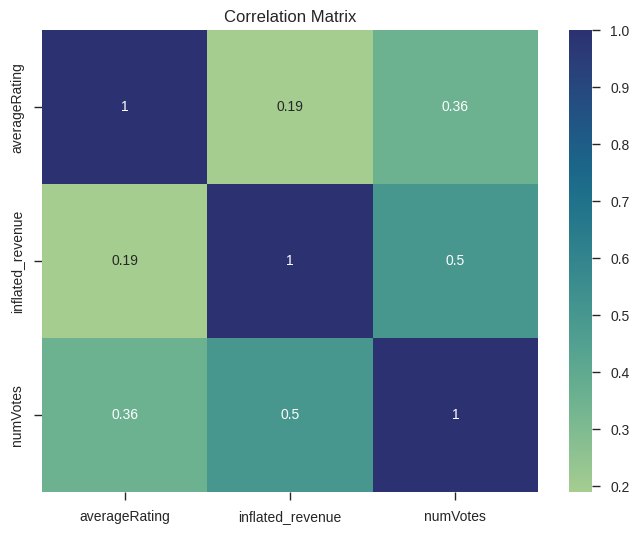

In [109]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_rating[["averageRating", "inflated_revenue", "numVotes"]].corr(),
    annot=True,
    cmap="crest",
)
plt.title("Correlation Matrix")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The Pearson correlation coefficient between IMDb rating and inflated revenue is 0.188, indicating a weak positive linear relationship.
  - The Spearman correlation coefficient is 0.157, suggests a weak monotonic relationship.

</div>

### Genre-wise Correlation
Different genres might exhibit different relationships between ratings and revenue.


#### Function to Calculate Correlations by Genre

In [110]:
def genre_correlation(genre):
    genre_data = df_rating[df_rating["genres_list"].apply(lambda x: genre in x)]
    pearson_corr, _ = pearsonr(
        genre_data["averageRating"], np.log10(genre_data["inflated_revenue"])
    )
    spearman_corr, _ = spearmanr(
        genre_data["averageRating"], np.log10(genre_data["inflated_revenue"])
    )
    return pd.Series(
        {"Genre": genre, "Pearson": pearson_corr, "Spearman": spearman_corr}
    )

#### Calculate Correlations by Genre

In [111]:
# get top 20 genres
genre_counts_filtered = genre_counts.head(20)
genres = genre_counts_filtered.index.tolist()
genre_corrs = pd.DataFrame([genre_correlation(genre) for genre in genres])
genre_corrs.set_index("Genre", inplace=True)
genre_corrs

Pearson  Spearman
Genre                               
Drama             0.217371  0.230485
Comedy            0.168477  0.186382
Thriller          0.238404  0.258994
Romance Film      0.184061  0.180027
Action            0.279959  0.327892
Action/Adventure  0.254966  0.306993
Crime Fiction     0.204603  0.227275
Adventure         0.255265  0.312972
Indie             0.211690  0.245956
Romantic comedy   0.211127  0.213484
Family Film       0.239712  0.307826
Romantic drama    0.177494  0.173142
Horror            0.235006  0.232137
Period piece      0.342387  0.413234
Mystery           0.250867  0.286732
Fantasy           0.228471  0.265596
Science Fiction   0.273600  0.292991
World cinema      0.033498  0.052916
Film adaptation   0.322260  0.410003
Crime Thriller    0.337234  0.320270

#### Visualizing Genre-wise Correlations

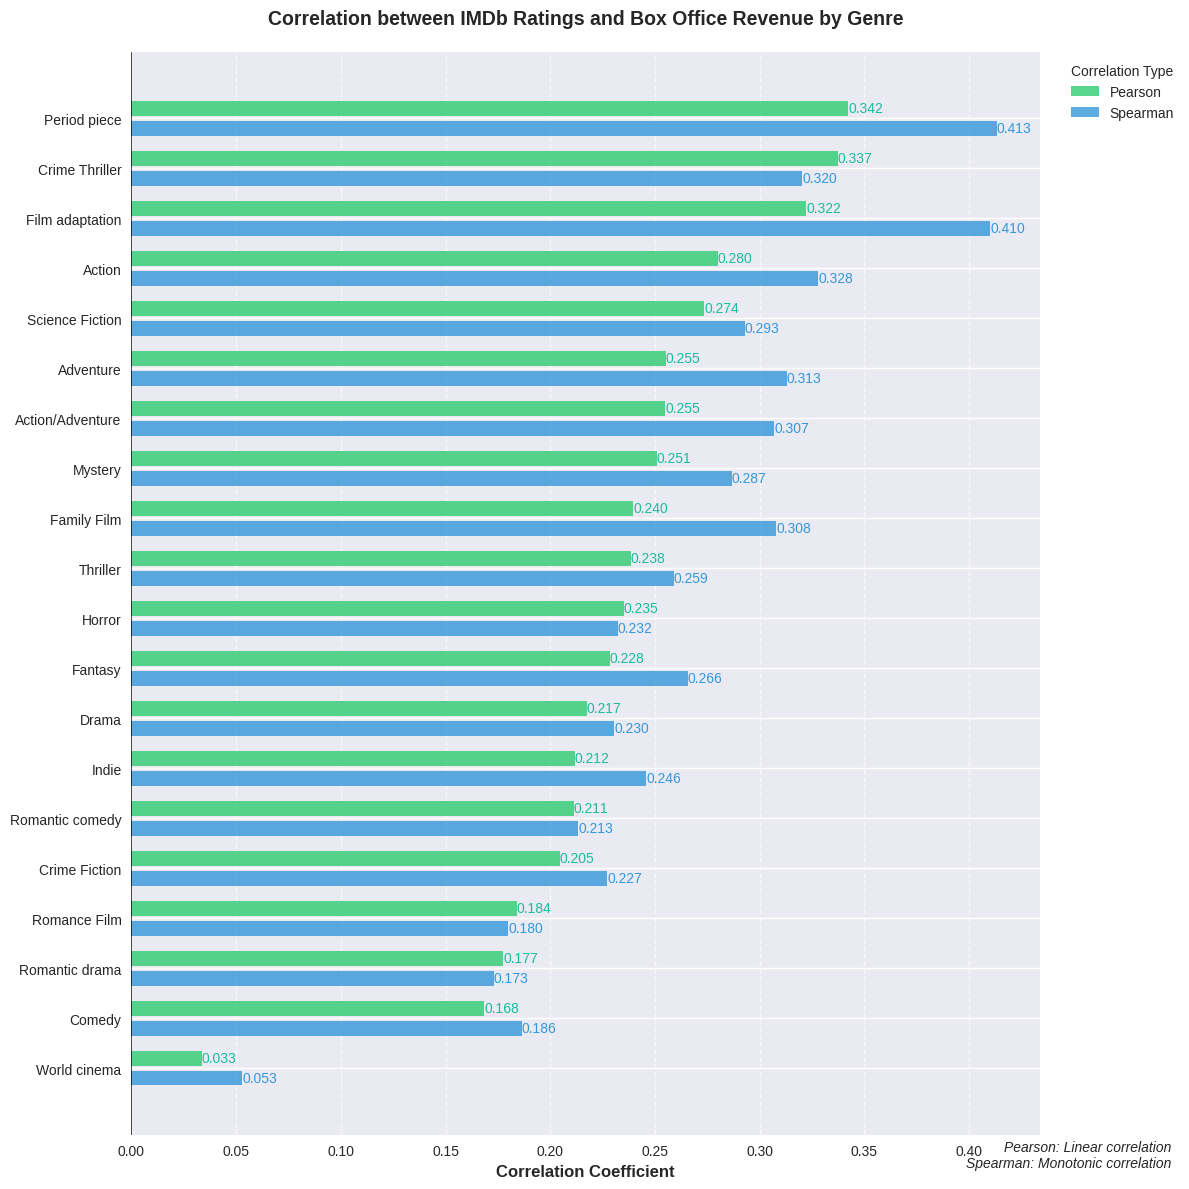

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Create figure
fig, ax = plt.subplots(figsize=(12, 12))

# Sort values for better visualization
genre_corrs_sorted = genre_corrs.sort_values("Pearson", ascending=True)

# Create horizontal bar plot with different colors for Pearson and Spearman
x_pearson = genre_corrs_sorted["Pearson"]
x_spearman = genre_corrs_sorted["Spearman"]
y = range(len(genre_corrs_sorted.index))

# update the x-y matching after reordering


# Plot horizontal bars
ax.barh(
    y=[i + 0.2 for i in y],
    width=x_pearson,
    height=0.3,
    color="#2ecc71",
    alpha=0.8,
    label="Pearson",
)
ax.barh(
    y=[i - 0.2 for i in y],
    width=x_spearman,
    height=0.3,
    color="#3498db",
    alpha=0.8,
    label="Spearman",
)

# Customize the plot
ax.set_yticks(y)
ax.set_yticklabels(genre_corrs_sorted.index, fontsize=10)
ax.set_xlabel("Correlation Coefficient", fontsize=12, fontweight="bold")
ax.set_title(
    "Correlation between IMDb Ratings and Box Office Revenue by Genre",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

# Add gridlines
ax.grid(True, axis="x", linestyle="--", alpha=0.7)

# Add zero line
ax.axvline(x=0, color="black", linestyle="-", linewidth=0.5)

# Add legend
ax.legend(
    title="Correlation Type",
    title_fontsize=10,
    fontsize=10,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
)

# Add value labels on the bars
for i in y:
    # Pearson values
    ax.text(
        x_pearson[i],
        i + 0.2,
        f"{x_pearson[i]:.3f}",
        va="center",
        ha="left" if x_pearson[i] >= 0 else "right",
        fontsize=10,
        color="#1abc9c",  # Modern teal color
    )
    # Spearman values
    ax.text(
        x_spearman[i],
        i - 0.2,
        f"{x_spearman[i]:.3f}",
        va="center",
        ha="left" if x_spearman[i] >= 0 else "right",
        fontsize=10,
        color="#3498db",  # Modern blue color
    )

# Add descriptive text
description = "Pearson: Linear correlation\n" "Spearman: Monotonic correlation"
plt.figtext(
    0.98, 0.02, description, fontsize=10, style="italic", ha="right", va="bottom"
)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Among the genres, some exhibit a stronger correlation between IMDb rating and box office revenue than others.
  - For example, Action movies have a positive correlation of 0.33, while World cinema movies have a near negligible correlation of 0.05.
  - Although the correlation values vary across genres, there is no genre with a negative correlation or a very strong positive correlation between IMDb rating and box office revenue.

</div>

### Regression Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  
</div>

#### Linear Regression Model

##### Simple Linear Regression

In [113]:
# Prepare the df_rating
X = df_rating[["averageRating"]]
y = np.log10(df_rating["inflated_revenue"])  # Log-transform the revenue

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     172.2
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           6.29e-39
Time:                        15:53:41   Log-Likelihood:                -11974.
No. Observations:                7935   AIC:                         2.395e+04
Df Residuals:                    7933   BIC:                         2.397e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.1373      0.082     74.471

##### Multiple Linear Regression: IMDb Rating and Number of Votes vs. Box Office Revenue

In [114]:
# Prepare the df_rating
X_multi = df_rating[["averageRating", "numVotes"]]
y_multi = np.log10(df_rating["inflated_revenue"])

# Log-transform numVotes to normalize
X_multi["log_numVotes"] = np.log10(X_multi["numVotes"])

# Add a constant term
X_multi = sm.add_constant(X_multi[["averageRating", "log_numVotes"]])

# Fit the model
model_multi = sm.OLS(y_multi, X_multi).fit()

# Model summary
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     1563.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:53:41   Log-Likelihood:                -10741.
No. Observations:                7935   AIC:                         2.149e+04
Df Residuals:                    7932   BIC:                         2.151e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.1264      0.080     51.676

/tmp/ipykernel_381043/1815284138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_multi["log_numVotes"] = np.log10(X_multi["numVotes"])


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - **Model Improvement:** Including log-transformed vote count significantly enhanced the model, with R² rising from 0.021 (rating-only) to 0.283, which shows vote count as a stronger revenue predictor than ratings alone.
  - **Surprising Rating Effect Shift:** Controlling for votes, the rating coefficient turns slightly negative (-0.0550) compared to its positive effect (0.1663) in the single predictor model. This indicates that higher ratings don’t necessarily increase revenue once popularity (votes) is considered. (Said's Note: This is a surprising result that may effect our other analysis in this section as well)
  - **Vote Count Impact**: The positive coefficient for log_numVotes (0.7979, p < 0.001) suggests a 10% vote count increase correlates with an 8% revenue boost, that highlights vote count as the primary revenue driver over rating quality.

</div>

#### 3D Visualization of Multiple Linear Regression Model

In [115]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

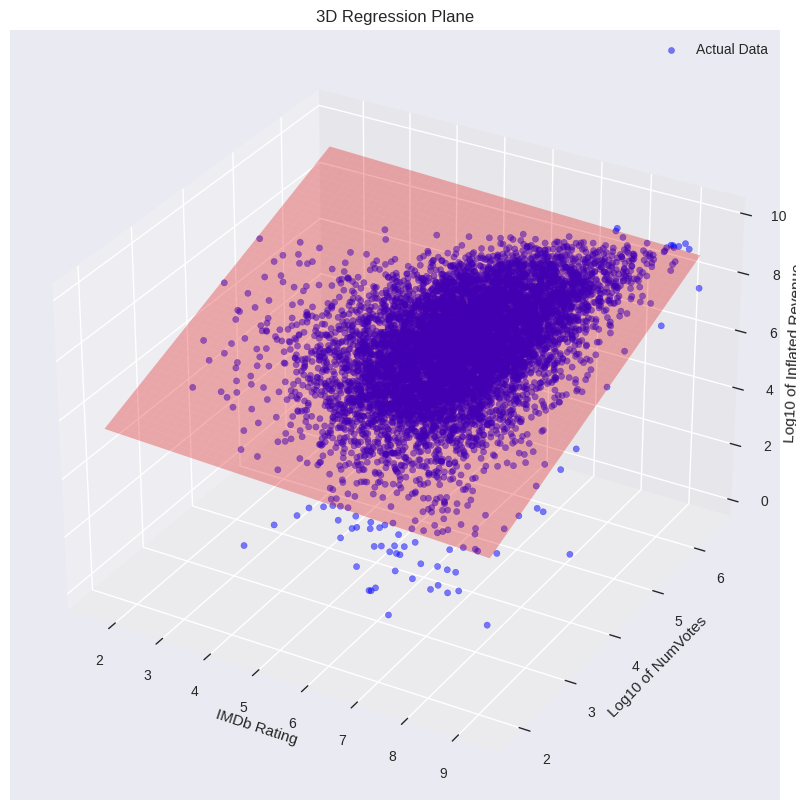

In [116]:
plt.style.use("seaborn-v0_8-notebook")
# Create a meshgrid for plotting
averageRating_range = np.linspace(
    df_rating["averageRating"].min(), df_rating["averageRating"].max(), 50
)
log_numVotes_range = np.linspace(
    np.log10(df_rating["numVotes"]).min(), np.log10(df_rating["numVotes"]).max(), 50
)
averageRating_grid, log_numVotes_grid = np.meshgrid(
    averageRating_range, log_numVotes_range
)
predicted_revenue = model_multi.predict(
    sm.add_constant(
        pd.DataFrame(
            {
                "averageRating": averageRating_grid.ravel(),
                "log_numVotes": log_numVotes_grid.ravel(),
            }
        )
    )
).values.reshape(averageRating_grid.shape)

# Plotting
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    df_rating["averageRating"],
    np.log10(df_rating["numVotes"]),
    np.log10(df_rating["inflated_revenue"]),
    c="blue",
    alpha=0.5,
    label="Actual Data",
)
ax.plot_surface(
    averageRating_grid, log_numVotes_grid, predicted_revenue, color="red", alpha=0.3
)
ax.set_xlabel("IMDb Rating")
ax.set_ylabel("Log10 of NumVotes")
ax.set_zlabel("Log10 of Inflated Revenue")
plt.title("3D Regression Plane")
plt.legend()
plt.show()

#### Regression Plot

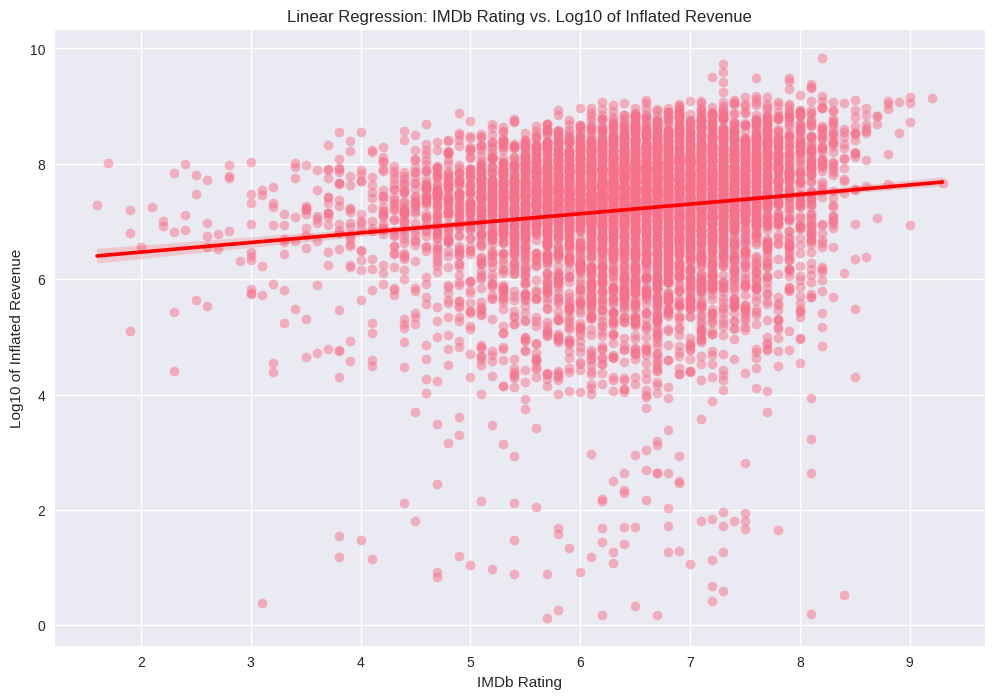

In [117]:
# TODO Said's Note: Since scatter plot is not a good choice to visualize the regression line for this task (as there are thousands of points), we may omit this plot (as the next plot is more informative with hexbins)
plt.figure(figsize=(12, 8))
sns.regplot(
    x="averageRating",
    y=np.log10(df_rating["inflated_revenue"]),
    data=df_rating,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)
plt.title("Linear Regression: IMDb Rating vs. Log10 of Inflated Revenue")
plt.xlabel("IMDb Rating")
plt.ylabel("Log10 of Inflated Revenue")
plt.show()

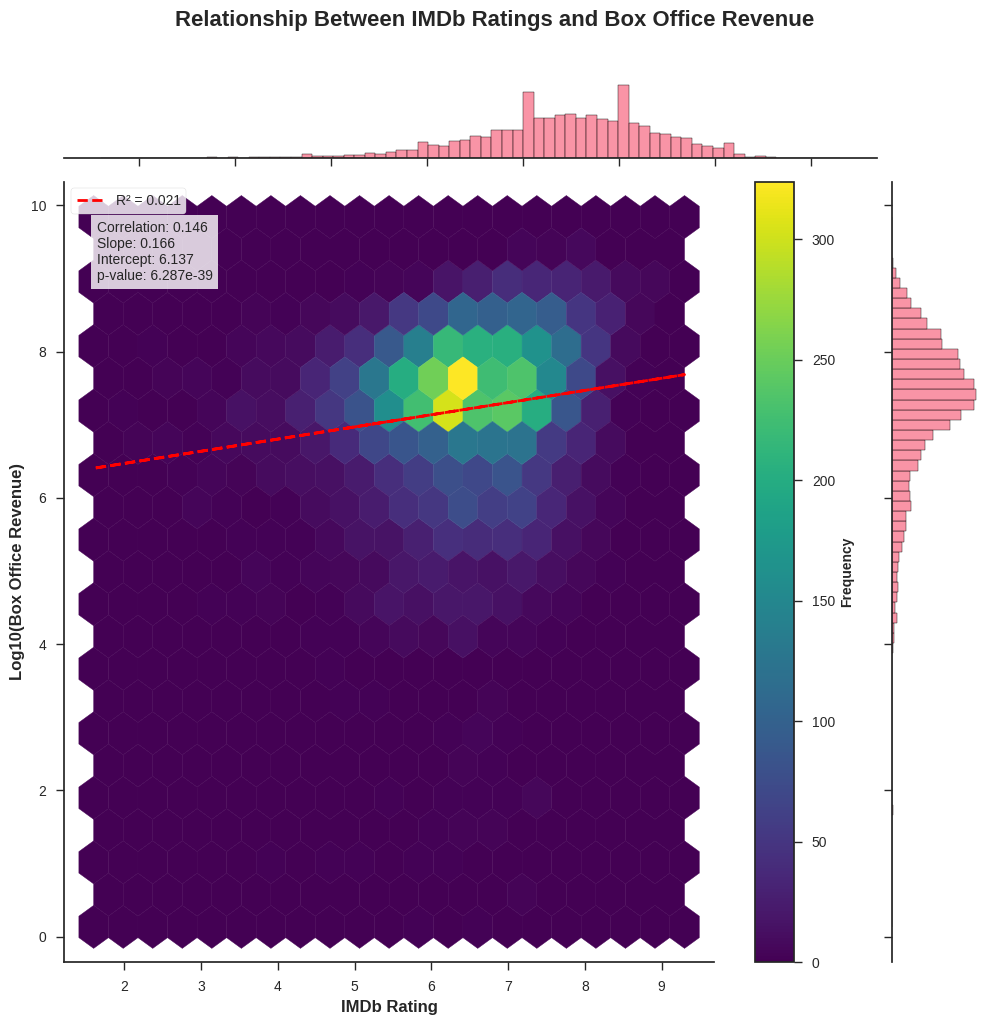

In [118]:
# Create figure with custom size and style
plt.style.use("seaborn-v0_8-ticks")
sns.set_palette("husl")

# Creation of the joint plot
g = sns.jointplot(
    data=df_rating,
    x="averageRating",
    y=np.log10(df_rating["inflated_revenue"]),
    kind="hex",
    height=10,  # figure size
    ratio=8,  # the ratio of main plot to marginal plots
    marginal_kws=dict(bins=70),  # More bins in marginal plots
    joint_kws=dict(gridsize=20),  # More hexbins for better resolution
    palette="viridis",  # Modern color palette
)

# Add trend line
x = df_rating["averageRating"]
y = np.log10(df_rating["inflated_revenue"])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
g.ax_joint.plot(
    x, line, color="red", linestyle="--", linewidth=2, label=f"R² = {r_value**2:.3f}"
)

# Customize the plot
g.figure.suptitle(
    "Relationship Between IMDb Ratings and Box Office Revenue",
    y=1.02,
    fontsize=16,
    fontweight="bold",
)

# Add descriptive labels
g.ax_joint.set_xlabel("IMDb Rating", fontsize=12, fontweight="bold")
g.ax_joint.set_ylabel("Log10(Box Office Revenue)", fontsize=12, fontweight="bold")

# Add legend with modern color
g.ax_joint.legend(loc="upper left", fontsize=10, frameon=True, facecolor="white")


# Add text box with statistics
stats_text = (
    f"Correlation: {r_value:.3f}\n"
    f"Slope: {slope:.3f}\n"
    f"Intercept: {intercept:.3f}\n"
    f"p-value: {p_value:.3e}"
)
g.ax_joint.text(
    0.05,
    0.95,
    stats_text,
    transform=g.ax_joint.transAxes,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    fontsize=10,
    verticalalignment="top",
)

# Customize hexbin appearance
g.ax_joint.collections[0].set_cmap("viridis")  # Modern colormap


# Add color bar
cbar = g.figure.colorbar(g.ax_joint.collections[0], ax=g.ax_joint, label="Count")
cbar.set_label("Frequency", fontsize=10, fontweight="bold")

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

## Movie 2: Tongues 🗣 How do the language and country of a movie influence its box office revenue?

The goal is to analyse in more detail how the language(s) and the country of origin of a movie influence it's box office revenue.

### Data pre-processing

A new, reduced dataframe can be created by only taking the relevant columns for this specific research question. The following columns are necessary:
- 'movie_name'
- 'movie_languages'
- 'movie_countries'
- 'inflated_revenue'

Three different dataframes are created:
- df_movie_country -> specific to the country only
- df_movie_language -> specific to the language only
- df_movie_country_language -> for both country and language 

In each dataframe, rows that don't contain any value for on of the mentioned columns are removed. 

In [119]:
# create the specific dataframes
df_movie_country = df[["movie_name", "movie_countries", "inflated_revenue"]]
df_movie_language = df[["movie_name", "movie_languages", "inflated_revenue"]]
df_movie_country_language = df[
    ["movie_name", "movie_languages", "movie_countries", "inflated_revenue"]
]

# drop rows with missing values
df_movie_country.dropna(inplace=True)
df_movie_language.dropna(inplace=True)
df_movie_country_language.dropna(inplace=True)

/tmp/ipykernel_381043/1981963934.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_country.dropna(inplace=True)
/tmp/ipykernel_381043/1981963934.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_language.dropna(inplace=True)
/tmp/ipykernel_381043/1981963934.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_country_language.dropna(inplace=True)


In [120]:
# print the number of rows where the movie_countries list is empty
print(
    "Number of rows where movie_countries list is empty: ",
    df_movie_country[df_movie_country["movie_countries"] == "[]"].shape[0],
)
# print the number of rows where the movie_languages list is empty
print(
    "Number of rows where movie_languages list is empty: ",
    df_movie_language[df_movie_language["movie_languages"] == "[]"].shape[0],
)

# remove such rows
df_movie_country = df_movie_country[
    df_movie_country["movie_countries"].apply(lambda x: len(ast.literal_eval(x)) > 0)
]
df_movie_language = df_movie_language[
    df_movie_language["movie_languages"].apply(lambda x: len(ast.literal_eval(x)) > 0)
]

# safety check
print("-----Preprocessed Data-----")
print(
    "Number of rows where movie_countries list is empty: ",
    df_movie_country[df_movie_country["movie_countries"] == "[]"].shape[0],
)
print(
    "Number of rows where movie_languages list is empty: ",
    df_movie_language[df_movie_language["movie_languages"] == "[]"].shape[0],
)

Number of rows where movie_countries list is empty:  131
Number of rows where movie_languages list is empty:  344
-----Preprocessed Data-----
Number of rows where movie_countries list is empty:  0
Number of rows where movie_languages list is empty:  0


In [121]:
# check for duplicates
print("Duplicates in df_movie_country: ", df_movie_country.duplicated().sum())
print("Duplicates in df_movie_language: ", df_movie_language.duplicated().sum())
print(
    "Duplicates in df_movie_country_language: ",
    df_movie_country_language.duplicated().sum(),
)

# remove duplicates
df_movie_country.drop_duplicates(inplace=True)
df_movie_language.drop_duplicates(inplace=True)
df_movie_country_language.drop_duplicates(inplace=True)

# safety check
print("-----Preprocessed Data-----")
print("Duplicates in df_movie_country: ", df_movie_country.duplicated().sum())
print("Duplicates in df_movie_language: ", df_movie_language.duplicated().sum())
print(
    "Duplicates in df_movie_country_language: ",
    df_movie_country_language.duplicated().sum(),
)

Duplicates in df_movie_country:  15
Duplicates in df_movie_language:  15
Duplicates in df_movie_country_language:  12
-----Preprocessed Data-----
Duplicates in df_movie_country:  0
Duplicates in df_movie_language:  0
Duplicates in df_movie_country_language:  0


/tmp/ipykernel_381043/2428558844.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_country_language.drop_duplicates(inplace=True)


In [122]:
df_movie_country.head()

movie_name                              movie_countries  \
0            Ghosts of Mars  [('/m/09c7w0', 'United States of America')]   
1  Alexander's Ragtime Band  [('/m/09c7w0', 'United States of America')]   
2                   Henry V             [('/m/07ssc', 'United Kingdom')]   
3              Mary Poppins  [('/m/09c7w0', 'United States of America')]   
4            New Rose Hotel  [('/m/09c7w0', 'United States of America')]   

   inflated_revenue  
0      1.899115e+07  
1      6.812740e+07  
2      1.967252e+07  
3      7.913870e+08  
4      3.100822e+04

In [123]:
df_movie_language.head()

movie_name                       movie_languages  \
0            Ghosts of Mars  [('/m/02h40lc', 'English Language')]   
1  Alexander's Ragtime Band  [('/m/02h40lc', 'English Language')]   
2                   Henry V  [('/m/02h40lc', 'English Language')]   
3              Mary Poppins  [('/m/02h40lc', 'English Language')]   
4            New Rose Hotel  [('/m/02h40lc', 'English Language')]   

   inflated_revenue  
0      1.899115e+07  
1      6.812740e+07  
2      1.967252e+07  
3      7.913870e+08  
4      3.100822e+04

In [124]:
df_movie_country_language.head()

movie_name                       movie_languages  \
0            Ghosts of Mars  [('/m/02h40lc', 'English Language')]   
1  Alexander's Ragtime Band  [('/m/02h40lc', 'English Language')]   
2                   Henry V  [('/m/02h40lc', 'English Language')]   
3              Mary Poppins  [('/m/02h40lc', 'English Language')]   
4            New Rose Hotel  [('/m/02h40lc', 'English Language')]   

                               movie_countries  inflated_revenue  
0  [('/m/09c7w0', 'United States of America')]      1.899115e+07  
1  [('/m/09c7w0', 'United States of America')]      6.812740e+07  
2             [('/m/07ssc', 'United Kingdom')]      1.967252e+07  
3  [('/m/09c7w0', 'United States of America')]      7.913870e+08  
4  [('/m/09c7w0', 'United States of America')]      3.100822e+04

### Some intial exploration

How many countries/ languages does the dataset have? Which ones are the most common one?

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the number of countries and languages in the dataset
  - Think about how this distribution could influence/ change further analysis
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Extract the unique country and language names and print the absolute frequency for the most common ones
  - Print the total number of different countries and languages
  - Visualization: Plot the most common countries and languages in a bar chart
</div>

In [125]:
def extract_names(columns):
    """
    Extracts the names from columns of the data (for countries and languages for example)
    Args:
        columns: list of columns
    Returns:
        names: list of names
    """
    names = []
    for column in columns:
        literals = ast.literal_eval(column)
        names.extend([literals[1] for literals in literals])
    return names

In [126]:
# extract all possible countries and languages
countries = extract_names(df_movie_country_language["movie_countries"])
languages = extract_names(df_movie_country_language["movie_languages"])

# count
countries_count = pd.Series(countries).value_counts()
languages_count = pd.Series(languages).value_counts()

# print the top 10 countries and languages
print(f"Top 10 countries:\n{countries_count.head(10)}")
print(f"Top 10 languages:\n{languages_count.head(10)}")

Top 10 countries:
United States of America    7691
United Kingdom              1121
France                       634
Germany                      519
Canada                       388
South Korea                  282
Japan                        237
Australia                    216
Italy                        196
India                        134
Name: count, dtype: int64
Top 10 languages:
English Language     8344
French Language       644
Spanish Language      484
German Language       308
Italian Language      279
Korean Language       258
Japanese Language     256
Russian Language      217
Standard Mandarin     145
Hindi Language        103
Name: count, dtype: int64


In [127]:
# print the number of different countries and languages
print(f"Number of different countries: {len(countries_count)}")
print(f"Number of different languages: {len(languages_count)}")

Number of different countries: 106
Number of different languages: 158


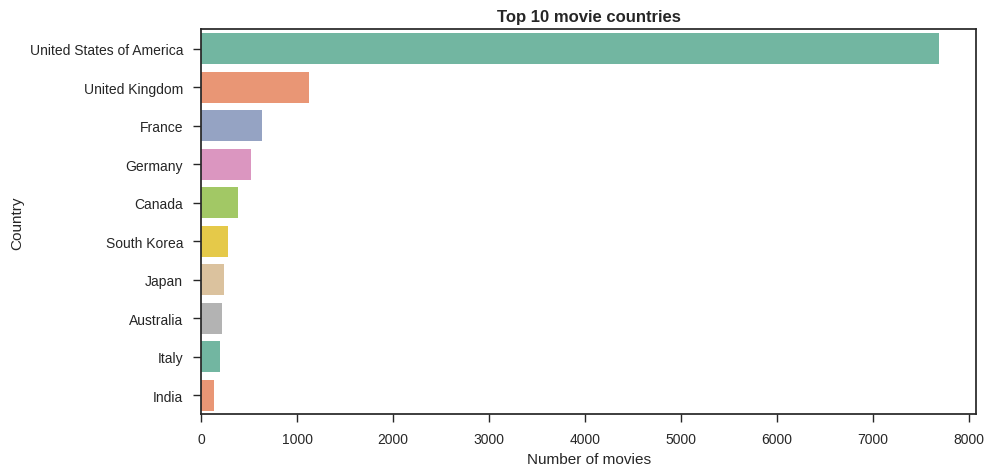

In [128]:
top_n = 10

# plot the top 10 countries
plt.figure(figsize=(10, 5))
sns.barplot(
    x=countries_count.head(top_n).values,
    y=countries_count.head(top_n).index,
    palette="Set2",
)
plt.title("Top 10 movie countries", fontweight="bold")
plt.xlabel("Number of movies")
plt.ylabel("Country")
plt.show()

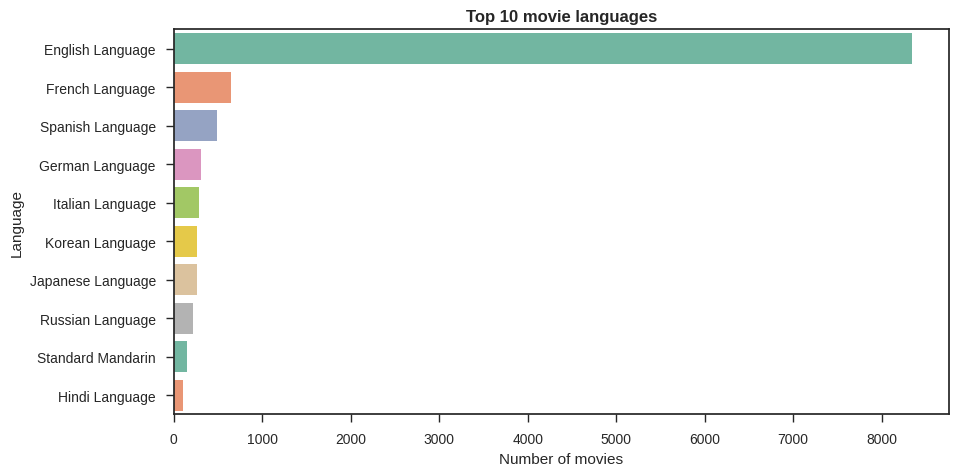

In [129]:
# plot the top 10 languages
plt.figure(figsize=(10, 5))
sns.barplot(
    x=languages_count.head(top_n).values,
    y=languages_count.head(top_n).index,
    palette="Set2",
)
plt.title("Top 10 movie languages", fontweight="bold")
plt.xlabel("Number of movies")
plt.ylabel("Language")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

</div>

### Language influence

How does the language influence the box office revenue? Do movies in widely spoken languages (for example English) tend to have higher box office revenue?

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the influence of the language on the box office revenue
  - Only consider the first mentioned language in the list of languages
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Extract the first language in the language list for each movie
  - Visualization: Plot the languages and their average box office revenue in a bar chart
  - Regression analysis
  - Statistical hypothesis testing: ANOVA
  
</div>

In [130]:
def extract_first_language(language_list):
    """
    Extract only the first language of the list of all languages
    Args:
        language_list: a list of all languages for a movie
    Returns:
        first_language: the first language for the given movie
    """
    parsed_language_list = ast.literal_eval(language_list)
    first_language = parsed_language_list[0][1]

    return first_language

In [131]:
# extract the first language for each movie
df_movie_language["first_language"] = df_movie_language["movie_languages"].apply(
    extract_first_language
)

# check
df_movie_language[["movie_name", "movie_languages", "first_language"]].head(10)

movie_name  \
0               Ghosts of Mars   
1     Alexander's Ragtime Band   
2                      Henry V   
3                 Mary Poppins   
4               New Rose Hotel   
5                     Baby Boy   
6   They Knew What They Wanted   
7       The Gods Must Be Crazy   
8                 Rudo y Cursi   
9  Kinjite: Forbidden Subjects   

                                     movie_languages      first_language  
0               [('/m/02h40lc', 'English Language')]    English Language  
1               [('/m/02h40lc', 'English Language')]    English Language  
2               [('/m/02h40lc', 'English Language')]    English Language  
3               [('/m/02h40lc', 'English Language')]    English Language  
4               [('/m/02h40lc', 'English Language')]    English Language  
5               [('/m/02h40lc', 'English Language')]    English Language  
6               [('/m/02h40lc', 'English Language')]    English Language  
7  [('/m/0x82', 'Afrikaans Language'), ('/m/02h40...  Afrikaans Language  
8                 [('/m/06nm1', 'Spanish Language')]    Spanish Language  
9               [('/m/02h40lc', 'English Language')]    English Language

In [132]:
# average box office revenue per language (only considering the fist languages for each movie)
average_revenue_per_language = (
    df_movie_language.groupby("first_language")["inflated_revenue"]
    .mean()
    .sort_values(ascending=False)
)

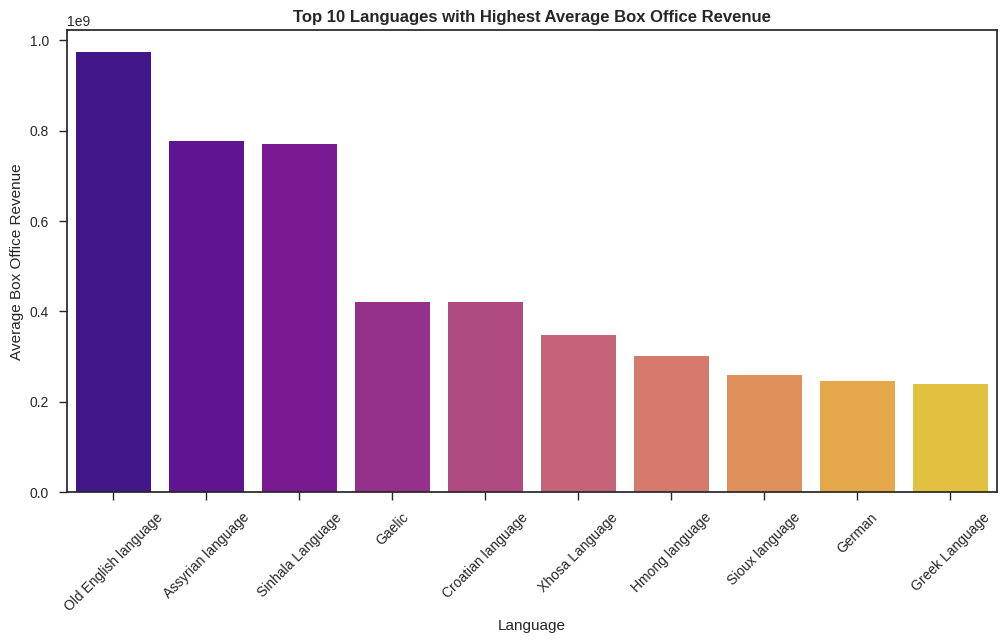

In [133]:
# plot
top_n = 10

plt.figure(figsize=(12, 6))
sns.barplot(
    x=average_revenue_per_language.head(top_n).index,
    y=average_revenue_per_language.head(top_n).values,
    palette="plasma",
)
plt.title("Top 10 Languages with Highest Average Box Office Revenue", fontweight="bold")
plt.xlabel("Language")
plt.ylabel("Average Box Office Revenue")
plt.xticks(rotation=45)
plt.show()

##### Regression analysis

The language (categorical) should predict the box office revenue (continuous). An ordinary least squares (OLS) regression can be done. The categorical variable has to be one-hot encoded. Each language will get an own coefficient, indicating its influence on the box office revenue compared to the baseline language.

In [134]:
# one-hot encode the language column
# baseline language -> the most common language
X = pd.get_dummies(df_movie_language["first_language"], drop_first=True).astype(int)

y = np.log10(df_movie_language["inflated_revenue"].astype(float))

# Add intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.028
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           4.01e-23
Time:                        15:53:44   Log-Likelihood:                -13691.
No. Observations:                9220   AIC:                         2.760e+04
Df Residuals:                    9112   BIC:                         2.837e+04
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [135]:
# todoooooooo -> take a threshold and remove the languages with less than that threshold
# then do the same analysis again
# make a fancy plot for the country
# comment the results
# anova with log revenue -> create a new column first, then do the same

##### ANOVA

An ANOVA analysis can be done in order to determine if there are statistically significant differences in box office revenue across different languages.

In [136]:
# define and fit the model
anova_model = ols("inflated_revenue ~ C(first_language)", data=df_movie_language).fit()
# get the anova table
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                         sum_sq      df         F        PR(>F)
C(first_language)  9.263444e+18   107.0  2.203867  1.716580e-11
Residual           3.579455e+20  9112.0       NaN           NaN


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  
  
</div>

### Country influence

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the influence of the country on the box office revenue
  - Only consider the first mentioned country in the list of countries
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Extract the first country in the country list for each movie
  - Visualization: Plot the countries and their average box office revenue in a bar chart
  - Regression analysis
  - Statistical hypothesis testing: ANOVA
  
</div>

In [137]:
# check if some rows have multiple countries (in the list of countries)
num_rows_with_multiple_countries = (
    df_movie_country["movie_countries"]
    .apply(lambda x: len(ast.literal_eval(x)) > 1)
    .sum()
)
print("Number of rows with more than one country:", num_rows_with_multiple_countries)

Number of rows with more than one country: 2198


In [138]:
def extract_first_country(country_list):
    """
    Extract only the first country of the list of all countries
    Args:
        country_list: a list of all countries for a movie
    Returns:
        first_country: the first country for the given movie
    """
    parsed_country_list = ast.literal_eval(country_list)
    first_country = parsed_country_list[0][1]

    return first_country

In [139]:
# only take the first country
df_movie_country["first_country"] = df_movie_country["movie_countries"].apply(
    extract_first_country
)

# check
df_movie_country[["movie_name", "movie_countries", "first_country"]].head(10)

movie_name  \
0               Ghosts of Mars   
1     Alexander's Ragtime Band   
2                      Henry V   
3                 Mary Poppins   
4               New Rose Hotel   
5                     Baby Boy   
6   They Knew What They Wanted   
7       The Gods Must Be Crazy   
8                 Rudo y Cursi   
9  Kinjite: Forbidden Subjects   

                                     movie_countries             first_country  
0        [('/m/09c7w0', 'United States of America')]  United States of America  
1        [('/m/09c7w0', 'United States of America')]  United States of America  
2                   [('/m/07ssc', 'United Kingdom')]            United Kingdom  
3        [('/m/09c7w0', 'United States of America')]  United States of America  
4        [('/m/09c7w0', 'United States of America')]  United States of America  
5        [('/m/09c7w0', 'United States of America')]  United States of America  
6        [('/m/09c7w0', 'United States of America')]  United States of America  
7                     [('/m/0hzlz', 'South Africa')]              South Africa  
8  [('/m/0b90_r', 'Mexico'), ('/m/09c7w0', 'Unite...                    Mexico  
9        [('/m/09c7w0', 'United States of America')]  United States of America

In [140]:
# average box office revenue per country (only considering the fist countries for each movie)
average_revenue_per_country = (
    df_movie_country.groupby("first_country")["inflated_revenue"]
    .mean()
    .sort_values(ascending=False)
)

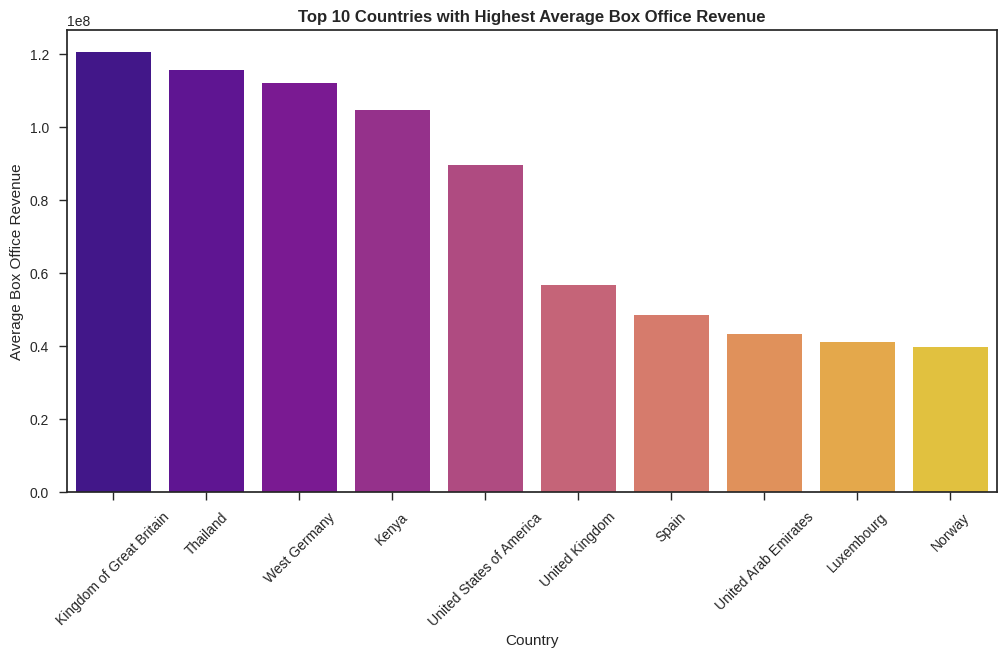

In [141]:
# plot
top_n = 10

plt.figure(figsize=(12, 6))
sns.barplot(
    x=average_revenue_per_country.head(top_n).index,
    y=average_revenue_per_country.head(top_n).values,
    palette="plasma",
)
plt.title("Top 10 Countries with Highest Average Box Office Revenue", fontweight="bold")
plt.xlabel("Country")
plt.ylabel("Average Box Office Revenue")
plt.xticks(rotation=45)
plt.show()

##### Regression analysis

The country (categorical) should predict the box office revenue (continuous). An ordinary least squares (OLS) regression can be done. The categorical variable has to be one-hot encoded. Each country will get an own coefficient, indicating its influence on the box office revenue compared to the baseline country.

In [142]:
# one-hot encode the country column
# baseline country -> the most common country
X = pd.get_dummies(df_movie_country["first_country"], drop_first=True).astype(int)

y = np.log10(df_movie_country["inflated_revenue"].astype(float))

# Add intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     10.22
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           7.89e-95
Time:                        15:53:45   Log-Likelihood:                -13944.
No. Observations:                9433   AIC:                         2.802e+04
Df Residuals:                    9368   BIC:                         2.848e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

##### ANOVA

An ANOVA analysis can be done in order to determine if there are statistically significant differences in box office revenue across different countries.

In [143]:
# define and fit the model
anova_model = ols("inflated_revenue ~ C(first_country)", data=df_movie_country).fit()
# get the anova table
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                        sum_sq      df         F        PR(>F)
C(first_country)  6.095020e+18    64.0  2.461818  9.507744e-10
Residual          3.623982e+20  9368.0       NaN           NaN


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  
</div>

### Relation between language and country

How are language and country correlated? What does this imply for previous and/ or further analysis?

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the correlation between the country and the language
  - Use the information to guide further anaylsis and to interpret previous one

</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Statistical hypothesis testing
  - Correlation analysis
  - Regression analyis
  
</div>

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

### Multilingual movies

Do multilingual movies have more success (in terms of box office revenues)? Is there a relationship between the number of languages spoken in a movie and its box office revenue?

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the influence of multilinguality in the movies
  - Keep in mind that if a movie has more than one language listed, it means the languages used in the original version (not the translations later on)

</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Statistical hypothesis testing (for the number of languages)
  
</div>

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

## Movie 3: Shades 🎭 How does a movie's genre impact its box office revenue?

In [144]:
df_genres = df[["movie_name", "movie_genres", "inflated_revenue", "release_year"]]

### Initial analysis

Before addressing our research question, it's important to familiarize ourselves with the dataset. To do this, we aim to answer the following questions:

- How many different genres are there in our dataset? 
- How many movies are there per genre?
- How many movies are categorized under more than one genre?

In [145]:
# convert string to list of genres
df_genres["movie_genres"] = df_genres["movie_genres"].apply(
    lambda x: [t[1] for t in eval(x)]
)

/tmp/ipykernel_381043/1321006551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genres["movie_genres"] = df_genres["movie_genres"].apply(


In [146]:
# get all unique genres across all movies
all_genres = set()
for genres in df_genres["movie_genres"]:
    all_genres.update(genres)

print(f"Number of unique genres: {len(all_genres)}")
print("Unique genres:")
print(sorted(all_genres))

Number of unique genres: 317
Unique genres:
['Absurdism', 'Acid western', 'Action', 'Action Comedy', 'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult', 'Adventure', 'Adventure Comedy', 'Airplanes and airports', 'Albino bias', 'Alien Film', 'Alien invasion', 'Americana', 'Animal Picture', 'Animals', 'Animated Musical', 'Animated cartoon', 'Animation', 'Anime', 'Anthology', 'Anthropology', 'Anti-war', 'Anti-war film', 'Apocalyptic and post-apocalyptic fiction', 'Archaeology', 'Archives and records', 'Art film', 'Auto racing', 'Avant-garde', 'B-Western', 'B-movie', 'Backstage Musical', 'Baseball', 'Beach Film', 'Bengali Cinema', 'Biker Film', 'Biographical film', 'Biography', 'Biopic [feature]', 'Black comedy', 'Black-and-white', 'Blaxploitation', 'Bloopers & Candid Camera', 'Bollywood', 'Boxing', 'Breakdance', 'British Empire Film', 'British New Wave', 'Buddy cop', 'Buddy film', 'Business', 'Camp', 'Caper story', 'Cavalry Film', 'Chase Movie', 'Childhood Drama', "Childre

In [147]:
# count number of movies per genre
genre_count = {}
for genres in df_genres["movie_genres"]:
    for genre in genres:
        if genre not in genre_count:
            genre_count[genre] = 0
        genre_count[genre] += 1

# convert to dataframe and sort by count
genre_df = pd.DataFrame.from_dict(genre_count, orient="index", columns=["count"])
genre_df = genre_df.sort_values("count", ascending=False)

print("Number of movies per genre:")
print(tabulate(genre_df, headers="keys", tablefmt="psql"))

Number of movies per genre:
+------------------------------------------+---------+
|                                          |   count |
|------------------------------------------+---------|
| Drama                                    |    5014 |
| Comedy                                   |    3516 |
| Romance Film                             |    2302 |
| Thriller                                 |    2265 |
| Action                                   |    2027 |
| Action/Adventure                         |    1553 |
| Crime Fiction                            |    1503 |
| Adventure                                |    1316 |
| Indie                                    |    1229 |
| Romantic comedy                          |     973 |
| Family Film                              |     925 |
| Romantic drama                           |     884 |
| Horror                                   |     875 |
| World cinema                             |     808 |
| Fantasy                            

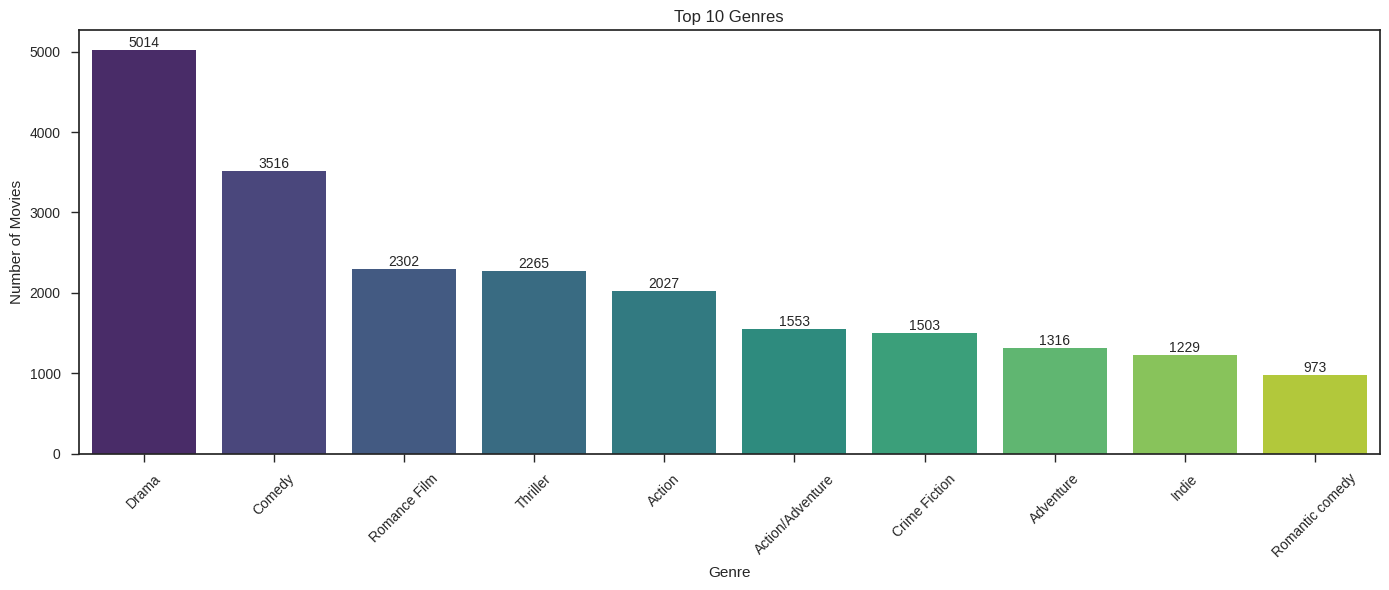

In [148]:
# plot top 10 most common genres as a bar plot
top_10_genres = genre_df.head(10)
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x=top_10_genres.index,
    y=top_10_genres["count"],
    hue=top_10_genres.index,
    palette="viridis",
)
# add the number of movies above each bar
for i, v in enumerate(top_10_genres["count"]):
    ax.text(i, v, str(int(v)), ha="center", va="bottom")
plt.xticks(rotation=45)
plt.title("Top 10 Genres")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

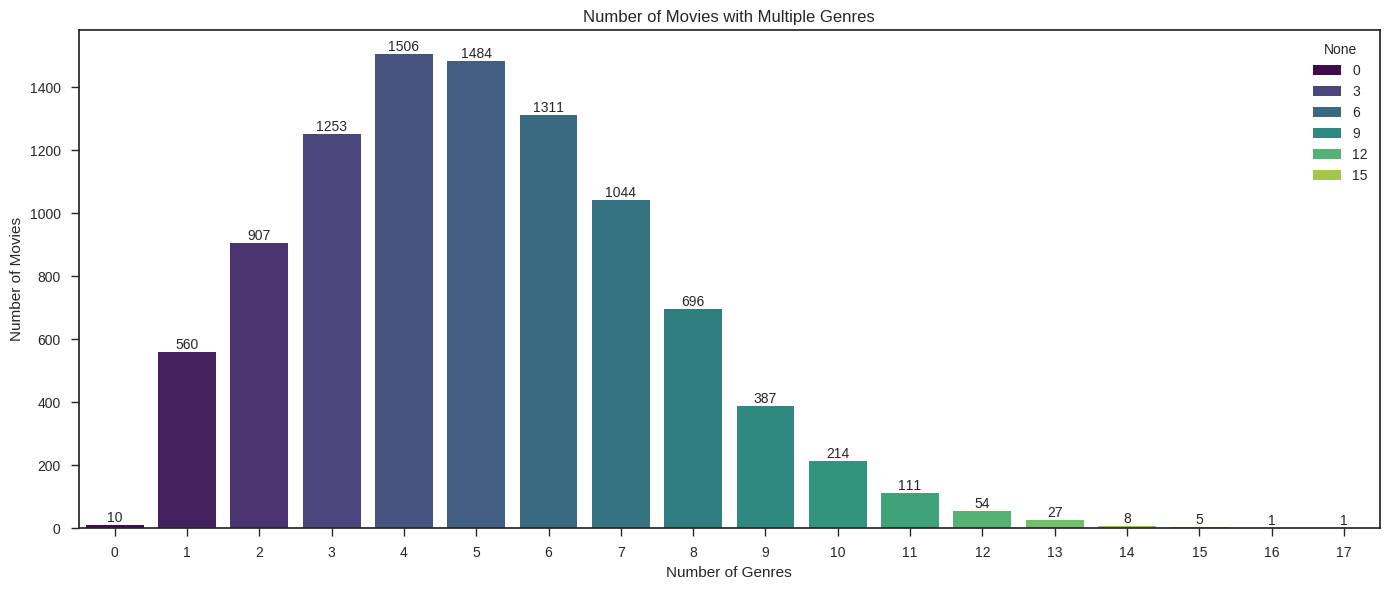

In [149]:
# count the movies with multiple genres
multi_genre_counts = {}
for genres in df_genres["movie_genres"]:
    if len(genres) not in multi_genre_counts:
        multi_genre_counts[len(genres)] = 0
    multi_genre_counts[len(genres)] += 1

# convert to dataframe and sort by count
multi_genre_df = pd.DataFrame.from_dict(
    multi_genre_counts, orient="index", columns=["count"]
)
multi_genre_df = multi_genre_df.sort_index()

# plot number of movies with multiple genres as a bar plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x=multi_genre_df.index,
    y=multi_genre_df["count"],
    hue=multi_genre_df.index,
    palette="viridis",
)
# add the number of movies above each bar
for i, v in enumerate(multi_genre_df["count"]):
    ax.text(i, v, str(int(v)), ha="center", va="bottom")
plt.title("Number of Movies with Multiple Genres")
plt.xlabel("Number of Genres")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

In [150]:
# print the percentage of movies with more than one genre
percentage = (len(df_genres) - multi_genre_counts[1]) / len(df_genres) * 100
print(
    f"Percentage of movies with more than one genre: {percentage:.2f}%",
)

Percentage of movies with more than one genre: 94.15%


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - There are 317 different genres in our dataset. 
  - The top 10 most common genres are: Drama, Comedy, Romance Film, Thriller, Action, Action/Adventure, Crime Fiction, Adventure, Indie and Romantic comedy.
  - 94.15 % of the movies have more than one genre.
</div>

Analyzing revenue patterns across all 317 genres in our dataset is impractical, so we will focus our analysis on the 10 most common genres.

In [151]:
# we will focus on the top 10 genres for the rest of the analysis
top_10_genres_list = sorted(genre_df.head(10).index.tolist())
print("Top 10 genres:")
print(top_10_genres_list)

# create a new dataframe with exploded genres, revenues and release years
df_genre_revenue = df_genres.explode("movie_genres")[
    ["movie_genres", "inflated_revenue", "release_year"]
]
# filter for only top-10 genres
df_genre_revenue = df_genre_revenue[
    df_genre_revenue["movie_genres"].isin(top_10_genres_list)
]
# sort by genre name
df_genre_revenue = df_genre_revenue.sort_values("movie_genres")
print("\nNumber of rows in the new exploded dataframe:", len(df_genre_revenue))

Top 10 genres:
['Action', 'Action/Adventure', 'Adventure', 'Comedy', 'Crime Fiction', 'Drama', 'Indie', 'Romance Film', 'Romantic comedy', 'Thriller']

Number of rows in the new exploded dataframe: 21698


<div class="alert alert-success">

  💭 <strong> Other ideas: </strong>
  
  - Should we also analyze the genre combinations, e.g. Drama + Romance?
  - Are movies with more than 1 genre more profitable?
  
</div>

### What are the average and median revenues for each genre?

This question aims to identify which genres tend to perform better financially and detect any clear outliers.

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Desctiptive statistics: mean, median, standard error of the mean
  - Visualization: bar plot
</div>

We will first compute the mean, median and standard error of the box office revenues for each of the top-10 genres.


In [152]:
# calculate average, median and standard error of the revenue per genre
genre_revenue_stats = (
    df_genre_revenue.groupby("movie_genres")
    .agg({"inflated_revenue": ["mean", "median", "sem"]})
    .round(2)
)

# rename columns
genre_revenue_stats.columns = ["mean", "median", "sem"]
# sort by mean revenue
genre_revenue_stats = genre_revenue_stats.sort_values("mean", ascending=False)

print("Revenue statistics by genre (in dollars):")
print(tabulate(genre_revenue_stats, headers="keys", tablefmt="psql"))

Revenue statistics by genre (in dollars):
+------------------+-------------+-------------+-------------+
| movie_genres     |        mean |      median |         sem |
|------------------+-------------+-------------+-------------|
| Adventure        | 1.77227e+08 | 4.9472e+07  | 9.41716e+06 |
| Action           | 1.29697e+08 | 4.00426e+07 | 5.10951e+06 |
| Action/Adventure | 1.19006e+08 | 3.95344e+07 | 5.10398e+06 |
| Thriller         | 9.73651e+07 | 3.20046e+07 | 3.78318e+06 |
| Romance Film     | 7.56037e+07 | 2.20915e+07 | 4.74556e+06 |
| Comedy           | 7.40884e+07 | 2.58359e+07 | 2.24098e+06 |
| Crime Fiction    | 7.28373e+07 | 2.07549e+07 | 3.43501e+06 |
| Drama            | 6.83878e+07 | 1.72904e+07 | 2.90103e+06 |
| Romantic comedy  | 6.29251e+07 | 2.66943e+07 | 3.162e+06   |
| Indie            | 2.20571e+07 | 3.54938e+06 | 1.6801e+06  |
+------------------+-------------+-------------+-------------+


For better interpretation, we will also use a bar plot to vizualize the means and standard error for each genre.

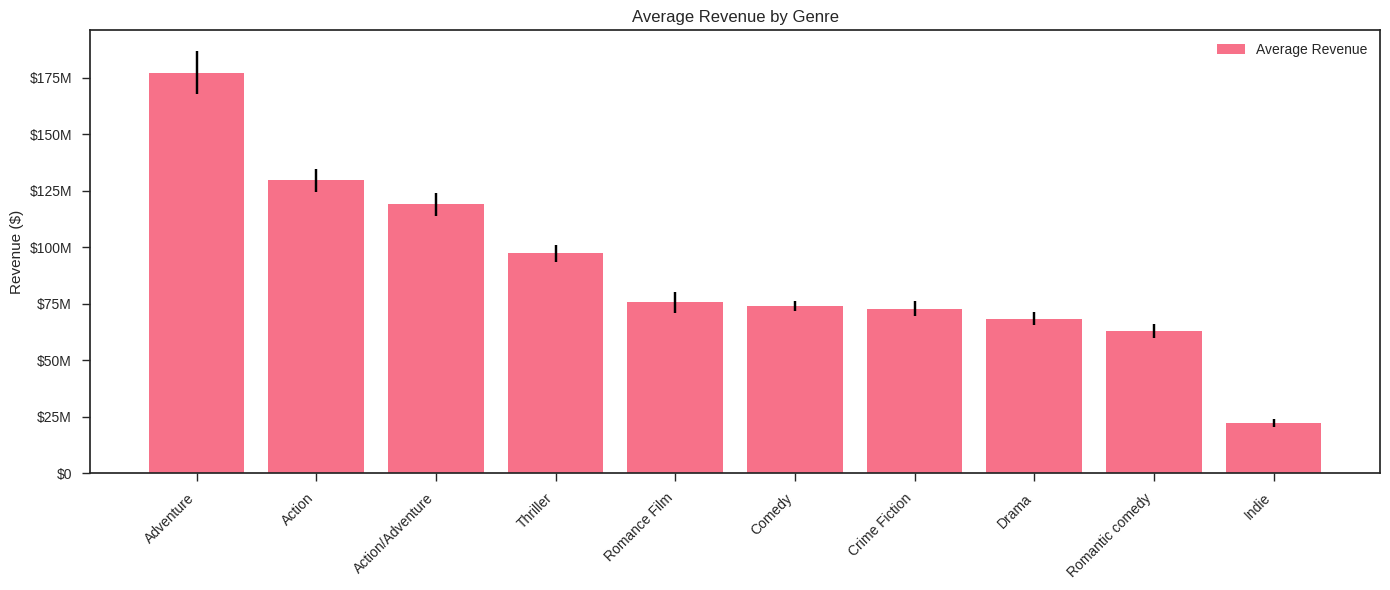

In [153]:
x = np.arange(len(genre_revenue_stats.index))
fig, ax = plt.subplots(figsize=(14, 6))
rects = ax.bar(
    x,
    genre_revenue_stats["mean"],
    label="Average Revenue",
    yerr=genre_revenue_stats["sem"],
)
ax.set_ylabel("Revenue ($)")
ax.set_title("Average Revenue by Genre")
ax.set_xticks(x)
ax.set_xticklabels(genre_revenue_stats.index, rotation=45, ha="right")
ax.legend()
# format y-axis to use dollars
ax.yaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - **Drama** is the most popular genre, appearing in 5042 movies. However, ranked by average revenue it is on the 8-th spot.
</div>

### What is the distribution of revenues within each genre? Are there high variability and skewness?

This question aims to explore if specific genres have wider distributions in revenue, indicating higher financial risk or reward. 

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Descriptive statistics: interquartile range, variance and skewness
  - Visualization: box plot or violin plot
</div>

In [154]:
# calculate interquartile range, variance and skewness for each genre
genre_revenue_stats = (
    df_genre_revenue.groupby("movie_genres")["inflated_revenue"]
    .agg(["min", "max", "mean", "median", "std", "var", "skew"])
    .round(2)
)
print("Revenue statistics by genre (in dollars):")
print(tabulate(genre_revenue_stats, headers="keys", tablefmt="psql"))

Revenue statistics by genre (in dollars):
+------------------+-------+-------------+-------------+-------------+-------------+-------------+--------+
| movie_genres     |   min |         max |        mean |      median |         std |         var |   skew |
|------------------+-------+-------------+-------------+-------------+-------------+-------------+--------|
| Action           |  1.36 | 3.11896e+09 | 1.29697e+08 | 4.00426e+07 | 2.30042e+08 | 5.29191e+16 |   4.38 |
| Action/Adventure |  1.36 | 2.75873e+09 | 1.19006e+08 | 3.95344e+07 | 2.01138e+08 | 4.04567e+16 |   3.96 |
| Adventure        |  1.53 | 5.28863e+09 | 1.77227e+08 | 4.9472e+07  | 3.41624e+08 | 1.16707e+17 |   5.77 |
| Comedy           |  1.53 | 1.27633e+09 | 7.40884e+07 | 2.58359e+07 | 1.32881e+08 | 1.76573e+16 |   3.69 |
| Crime Fiction    |  2.19 | 1.40656e+09 | 7.28373e+07 | 2.07549e+07 | 1.3317e+08  | 1.77344e+16 |   3.85 |
| Drama            |  1.5  | 6.90559e+09 | 6.83878e+07 | 1.72904e+07 | 2.05421e+08 | 4.21978e+

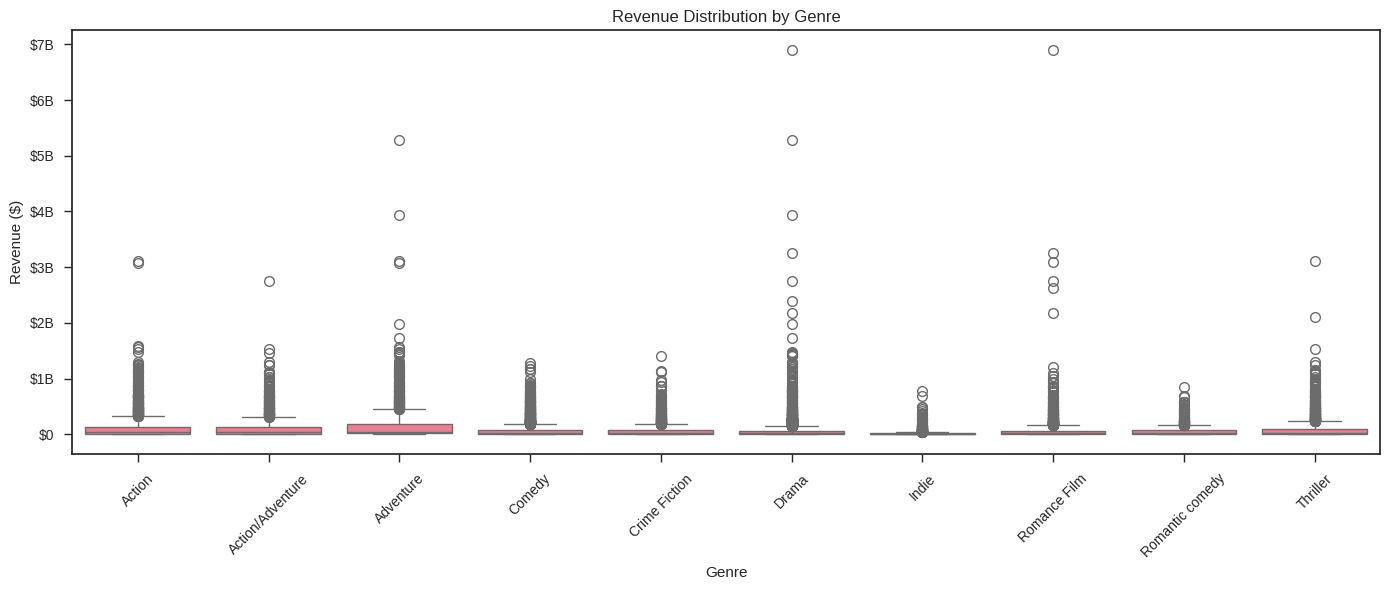

In [155]:
# plot box plots for each genre
plt.figure(figsize=(14, 6))
sns.boxplot(
    x="movie_genres", y="inflated_revenue", data=df_genre_revenue, showfliers=True
)  # TODO: when True the outliers are shown (doesn't look good)
plt.xticks(rotation=45)
plt.title("Revenue Distribution by Genre")
plt.xlabel("Genre")
plt.ylabel("Revenue ($)")
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
</div>


### How has the revenue of each genre changed over time?

This question aims to answer whether certain genres have more (or less) popular or profitable over time.

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Visualization: Line plot
</div>

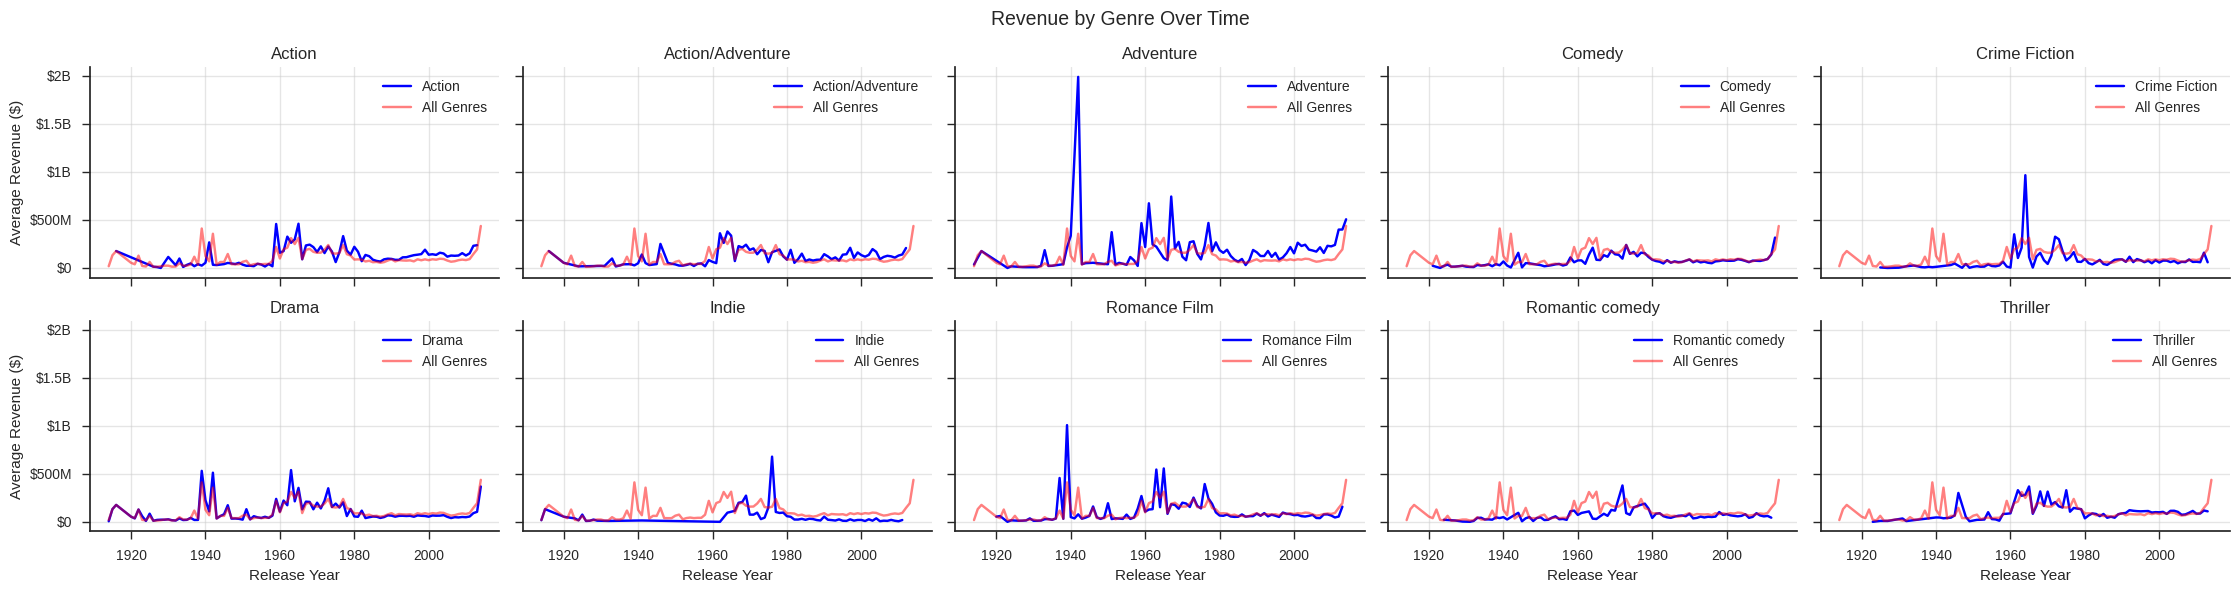

In [156]:
# calculate average revenue by year
year_avg_revenue = (
    df_genre_revenue.groupby("release_year")["inflated_revenue"].mean().reset_index()
)
# calculate average revenue by genre and year
genre_year_avg_revenue = (
    df_genre_revenue.groupby(["movie_genres", "release_year"])["inflated_revenue"]
    .mean()
    .reset_index()
)

# create a facet grid of line plots for each genre
g = sns.FacetGrid(
    data=genre_year_avg_revenue, col="movie_genres", col_wrap=5, height=3, aspect=1.5
)

for ax, genre in zip(g.axes, top_10_genres_list):
    revenue_data = genre_year_avg_revenue[
        genre_year_avg_revenue["movie_genres"] == genre
    ]
    ax.plot(
        revenue_data["release_year"],
        revenue_data["inflated_revenue"],
        color="blue",
        label=f"{genre}",
    )
    ax.plot(
        year_avg_revenue["release_year"],
        year_avg_revenue["inflated_revenue"],
        color="red",
        alpha=0.5,
        label="All Genres",
    )
    ax.set_xlabel("Release Year")
    ax.set_ylabel("Average Revenue ($)")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))
    ax.tick_params(axis="y")
    ax.grid(True, alpha=0.5)
    ax.set_title(genre)
    ax.legend(loc="upper right")

plt.suptitle("Revenue by Genre Over Time", fontsize=14)
plt.tight_layout()
plt.show()

# TODO: What happened with Adventure movies around the 1940s?

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

</div>


### Are there any trends in genre popularity over time, and how do they correlate with revenue changes?

This question aims to determine if changes in revenue for a genre correspond with changes in the number of movies produced in that genre.


<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Visualization: Line plot
  - Correlation coefficient: Pearson and Spearman
</div>

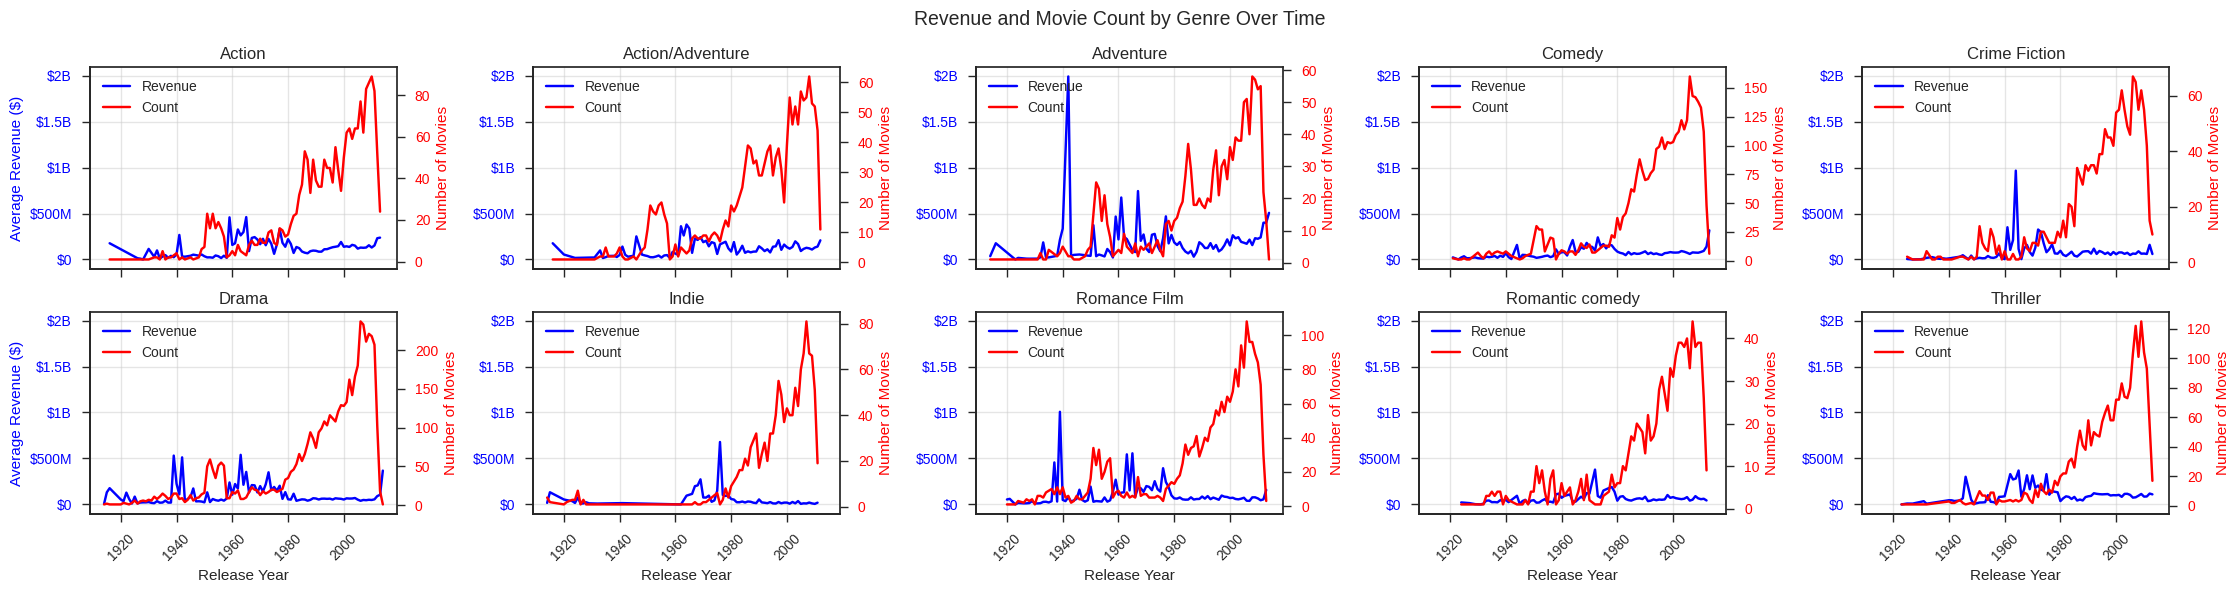

In [157]:
# TODO: Is it a good idea to only count movies that have a revenue?
# TODO: Explain the drop in the number of movies after 2000.

# calculate number of movies per genre per year
genre_year_counts = (
    df_genre_revenue.groupby(["movie_genres", "release_year"])
    .size()
    .reset_index(name="count")
)
# create a facet grid of line plots for each genre
g = sns.FacetGrid(
    data=genre_year_avg_revenue, col="movie_genres", col_wrap=5, height=3, aspect=1.5
)

# plot revenue on primary y-axis
for ax, genre in zip(g.axes, genre_year_avg_revenue["movie_genres"].unique()):
    # revenue plot
    revenue_data = genre_year_avg_revenue[
        genre_year_avg_revenue["movie_genres"] == genre
    ]
    ax1 = ax
    ln1 = ax1.plot(
        revenue_data["release_year"],
        revenue_data["inflated_revenue"],
        color="blue",
        label="Revenue",
    )
    ax1.set_xlabel("Release Year")
    ax1.set_ylabel("Average Revenue ($)", color="blue")
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))
    ax1.tick_params(axis="y", labelcolor="blue")

    # number of movies plot
    ax2 = ax1.twinx()
    count_data = genre_year_counts[genre_year_counts["movie_genres"] == genre]
    ln2 = ax2.plot(
        count_data["release_year"], count_data["count"], color="red", label="Count"
    )
    ax2.set_ylabel("Number of Movies", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # formatting
    ax1.tick_params(axis="x", rotation=45)
    ax1.grid(True, alpha=0.5)
    ax.set_title(genre)

    # legend
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc="upper left")

plt.suptitle("Revenue and Movie Count by Genre Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [158]:
results = []  # empty list to store the results
for genre in top_10_genres_list:
    # extract average revenue for the genre
    genre_average_revenue = genre_year_avg_revenue[
        genre_year_avg_revenue["movie_genres"] == genre
    ]["inflated_revenue"]
    # extract number of movies for the genre
    genre_count = genre_year_counts[genre_year_counts["movie_genres"] == genre]["count"]
    # calculate Pearson and Spearman correlation coefficients
    pearson_correlation, pearson_p_value = stats.pearsonr(
        genre_average_revenue, genre_count
    )
    spearman_correlation, spearman_p_value = stats.spearmanr(
        genre_average_revenue, genre_count
    )
    # append the results to the list
    results.append(
        {
            "Genre": genre,
            "Pearson Correlation": f"{pearson_correlation:.2f}",
            "Pearson p-value": f"{pearson_p_value:.2f}",
            "Spearman Correlation": f"{spearman_correlation:.2f}",
            "Spearman p-value": f"{spearman_p_value:.2f}",
        }
    )

# convert the list of results to a dataframe
correlation_df = pd.DataFrame(results)
print(tabulate(correlation_df, headers="keys", tablefmt="psql", showindex=False))

+------------------+-----------------------+-------------------+------------------------+--------------------+
| Genre            |   Pearson Correlation |   Pearson p-value |   Spearman Correlation |   Spearman p-value |
|------------------+-----------------------+-------------------+------------------------+--------------------|
| Action           |                  0.04 |              0.69 |                   0.24 |               0.03 |
| Action/Adventure |                  0.03 |              0.77 |                   0.21 |               0.06 |
| Adventure        |                 -0.05 |              0.65 |                   0.24 |               0.03 |
| Comedy           |                  0.01 |              0.94 |                   0.34 |               0    |
| Crime Fiction    |                 -0.05 |              0.67 |                   0.39 |               0    |
| Drama            |                 -0.26 |              0.01 |                   0.01 |               0.89 |
|

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

## Movie 4: Starlight 💫 To what extent is a movie's box office revenue influenced by its director?

### Initial analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

</div>

In [159]:
sns.set_palette("blend:#7AB,#EDA")
custom_colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
]
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=custom_colors)

- What is the highest inflated revenue each year?
- Which directors generate the most revenue?
- Which directors produce the most movies?
- Who generated the best average revenue per movie?

#### What is the highest inflated revenue each year?

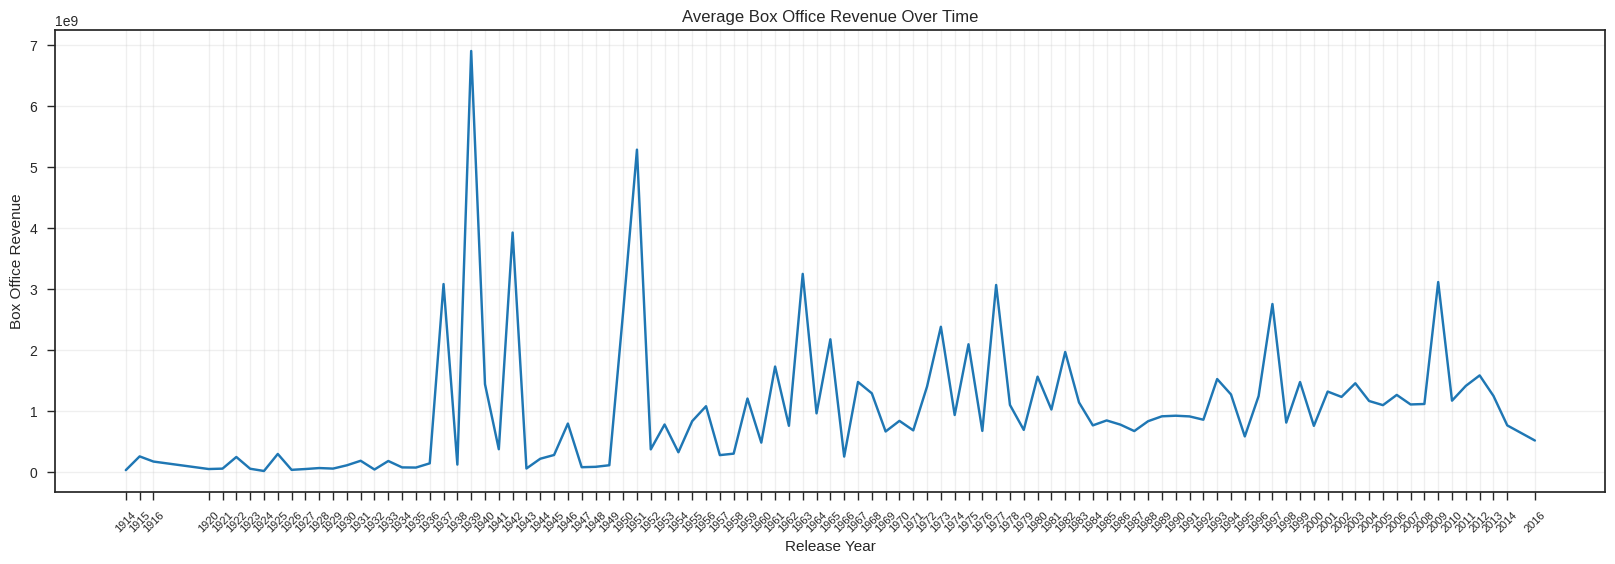

In [160]:
plt.figure(figsize=(20, 6))
yearly_inflated_avg = df.groupby("release_year")["inflated_revenue"].max()
sns.lineplot(x=yearly_inflated_avg.index, y=yearly_inflated_avg.values)
plt.title("Average Box Office Revenue Over Time")
plt.xlabel("Release Year")
plt.ylabel("Box Office Revenue")
plt.xticks(yearly_inflated_avg.index, rotation=45, fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - We can see that the highest inflated revenue movie is in 1939
</div>

In [161]:
df_dir = df[["director", "inflated_revenue", "release_year", "movie_name"]]
df_dir[df_dir["inflated_revenue"] == df_dir["inflated_revenue"].max()]

director  inflated_revenue  release_year          movie_name
4499  Victor Fleming      6.905588e+09        1939.0  Gone with the Wind

#### Which directors generate the most revenue?

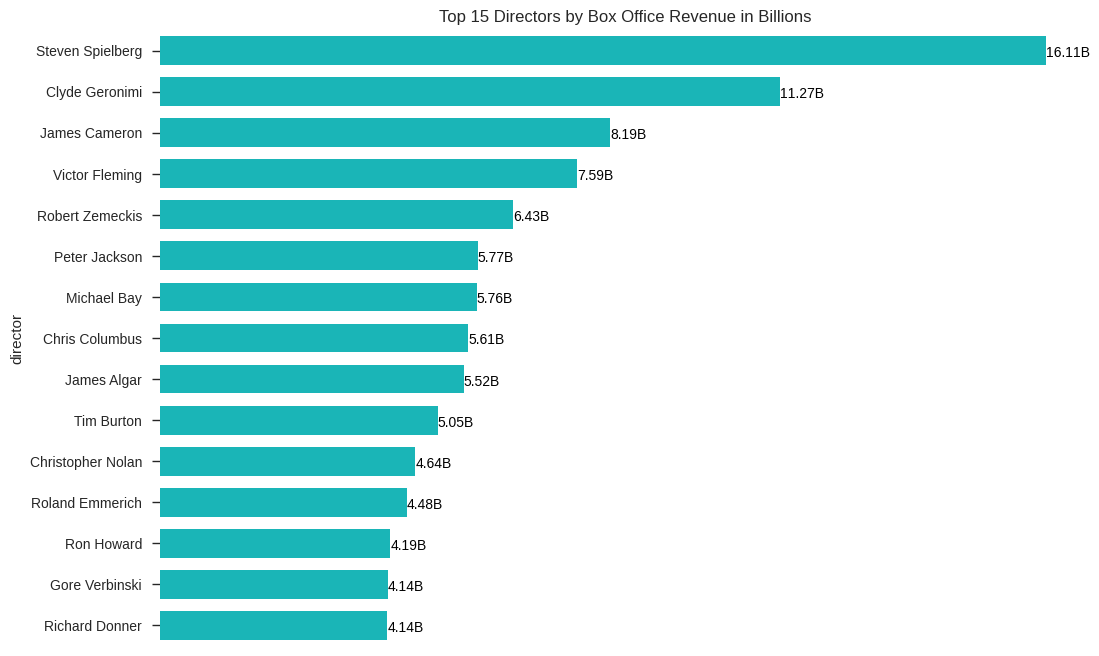

In [162]:
df_dir = df_dir[df_dir["director"] != "Unknown"]
df_top_dir = (
    df_dir.groupby("director")
    .sum()
    .sort_values(by="inflated_revenue", ascending=False)
    .head(15)
)
df_top_dir.reset_index(inplace=True)
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y="director", x="inflated_revenue", data=df_top_dir, width=0.7, color="#00CED1"
)
# hide x axis
ax.xaxis.set_visible(False)
# put the inflated revenue on the right side of the bar in billions
ax.set_title("Top 15 Directors by Box Office Revenue in Billions")
for i in ax.patches:
    ax.text(
        i.get_width() + 0.5,
        i.get_y() + 0.5,
        str(round(i.get_width() / 1e9, 2)) + "B",
        fontsize=10,
        color="black",
    )
plt.box(False)

#### Which directors produce the most movies?

Text(0.5, 1.0, 'Top 15 Directors by Number of Movies')

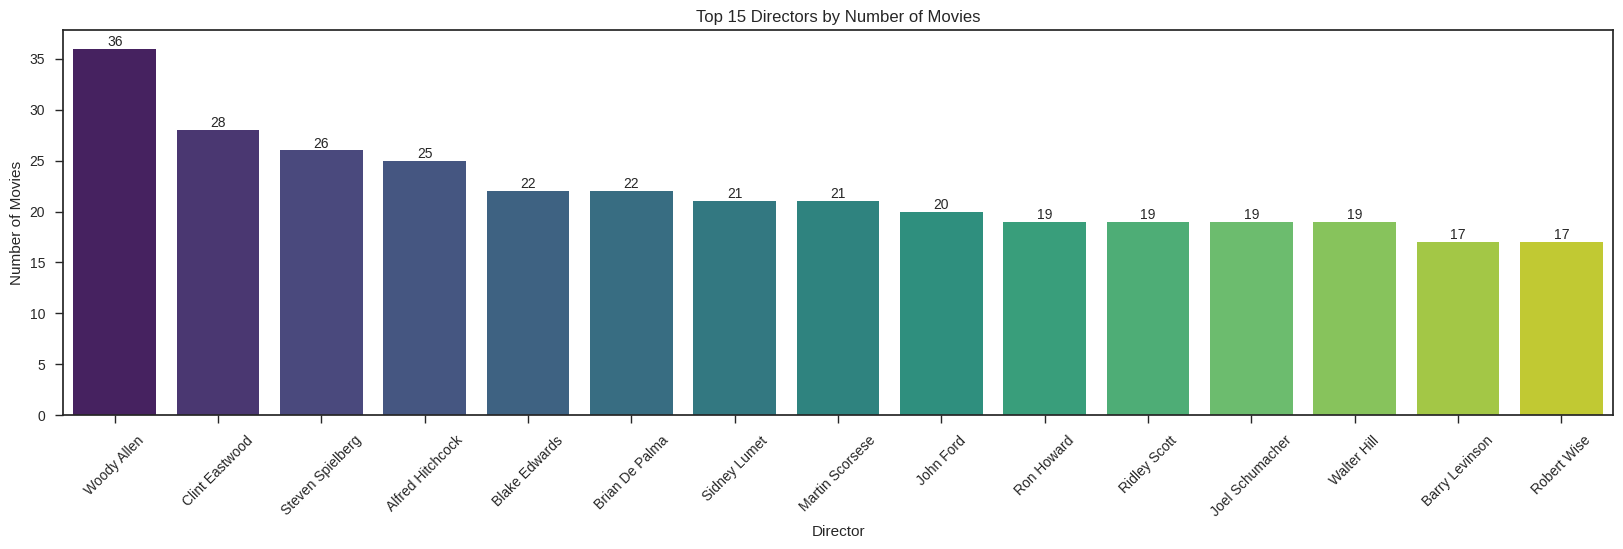

In [163]:
# plot top 10 directors by number of movies
df_count = df_dir["director"].value_counts().head(15)
plt.figure(figsize=(20, 5))
# add numbers above bars
ax = sns.barplot(x=df_count.index, y=df_count.values, palette="viridis")
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45)
plt.xlabel("Director")
plt.ylabel("Number of Movies")
plt.title("Top 15 Directors by Number of Movies")

#### Who generated the best average revenue per movie?

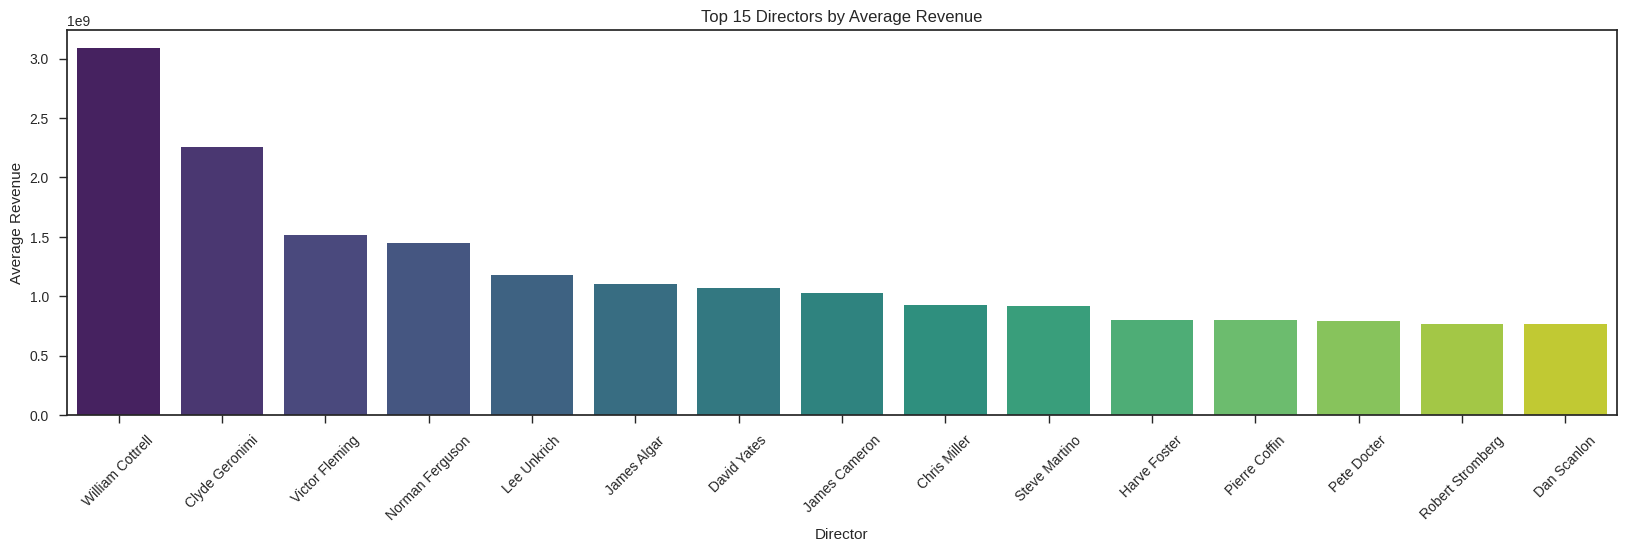

In [164]:
# plot top 15 revenue generating directors average revenue
df_mean = (
    df_dir[["director", "inflated_revenue"]]
    .groupby("director")
    .mean()
    .sort_values(by="inflated_revenue", ascending=False)
    .head(15)
)
plt.figure(figsize=(20, 5))
# add numbers above bars
ax = sns.barplot(x=df_mean.index, y=df_mean["inflated_revenue"], palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Director")
plt.ylabel("Average Revenue")
plt.title("Top 15 Directors by Average Revenue")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

### Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

</div>

#### Is each year's highest revenue movie directed by the same director?

/tmp/ipykernel_381043/2124195539.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dir_reduced_year["release_year"] = df_dir_reduced_year["release_year"].astype(int)
/tmp/ipykernel_381043/2124195539.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(top, "inflated_revenue"))


<Figure size 2000x1500 with 0 Axes>

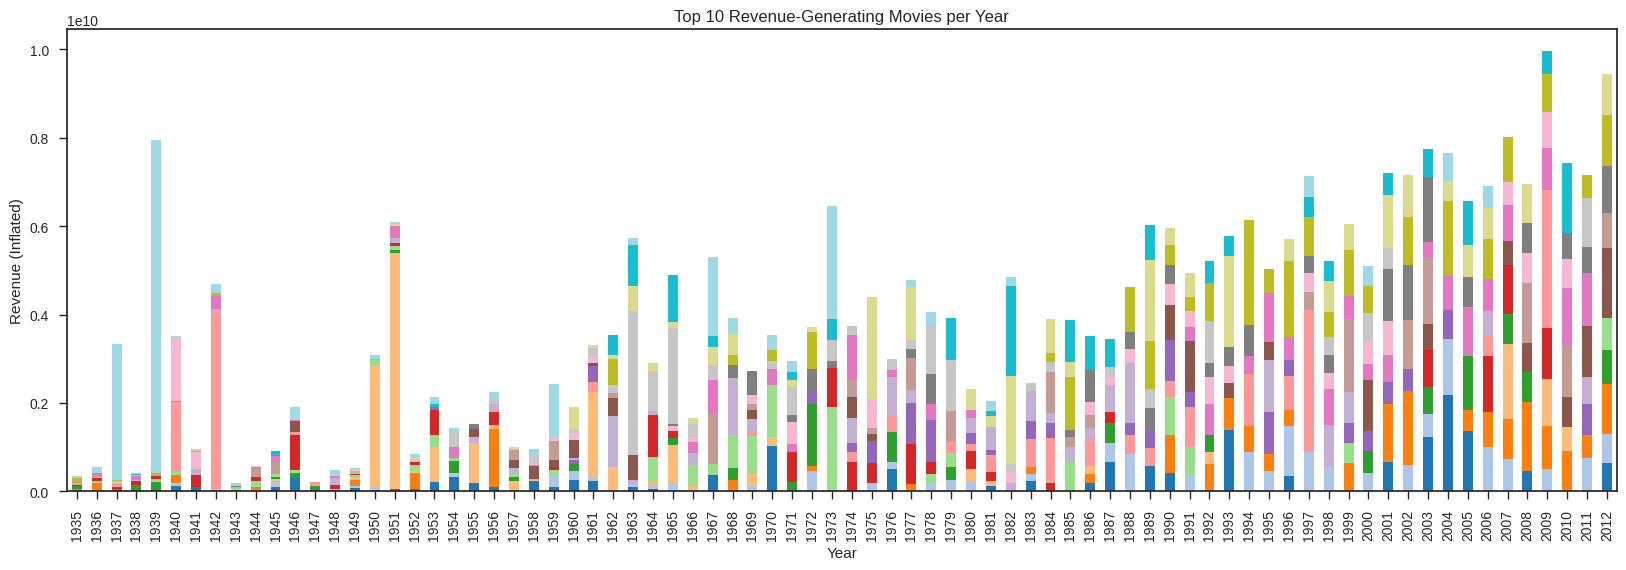

In [165]:
# Group by year and get the top 3 movies by revenue per year without sorting
df_dir_reduced_year = df_dir[
    (df_dir["release_year"] >= 1935) & (df_dir["release_year"] <= 2012)
]  # cleaner data
df_dir_reduced_year["release_year"] = df_dir_reduced_year["release_year"].astype(int)
top = 10
df_top = (
    df_dir_reduced_year.groupby("release_year")
    .apply(lambda x: x.nlargest(top, "inflated_revenue"))
    .reset_index(drop=True)
)

# Grouping and preparing data for plotting
yearly_director_revenue = (
    df_top.groupby(["release_year", "director"])["inflated_revenue"]
    .sum()
    .unstack(fill_value=0)
)
# For each year I want the to get the director with the highest revenue and sort the columns by that
# Code Here
# Find the top director per year (the one with the highest revenue)
top_director_per_year = yearly_director_revenue.idxmax(axis=1)


# Plotting
plt.figure(figsize=(20, 15))

# Prepare the data for plotting: reorder so that the top director's revenue comes first
yearly_director_revenue_sorted = yearly_director_revenue.apply(
    lambda row: row.sort_values(ascending=False), axis=1
)

# Plotting with stacked bars
ax = yearly_director_revenue_sorted.plot(
    kind="bar", stacked=True, figsize=(20, 6), cmap="tab20"
)


# Customize the plot
plt.title(f"Top {top} Revenue-Generating Movies per Year")
plt.xlabel("Year")
plt.ylabel("Revenue (Inflated)")

# Remove the legend
ax.legend().remove()

plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

## Movie 5: Waves 🌊 How much is a movie’s box office revenue influenced by its release timing and duration?

In [166]:
# load the dataset
df_season = df[
    [
        "movie_release_date",
        "inflated_revenue",
        "release_day",
        "release_month",
        "release_year",
        "movie_genres",
        "movie_runtime",
    ]
]

df_season.head()

movie_release_date  inflated_revenue  release_day  release_month  \
0         2001-08-24      1.899115e+07         24.0            8.0   
1         1938-08-16      6.812740e+07         16.0            8.0   
2         1989-11-08      1.967252e+07          8.0           11.0   
3         1964-08-27      7.913870e+08         27.0            8.0   
4         1999-10-01      3.100822e+04          1.0           10.0   

   release_year                                       movie_genres  \
0        2001.0  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...   
1        1938.0  [('/m/04t36', 'Musical'), ('/m/01z4y', 'Comedy...   
2        1989.0  [('/m/04xvh5', 'Costume drama'), ('/m/082gq', ...   
3        1964.0  [('/m/0hj3myq', "Children's/Family"), ('/m/04t...   
4        1999.0  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...   

   movie_runtime  
0           98.0  
1          106.0  
2          137.0  
3          139.0  
4           92.0

### Defining seasons

In [167]:
def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
    else:
        return np.nan  # Handle missing or invalid months


df_season["season"] = df_season["release_month"].apply(assign_season)

/tmp/ipykernel_381043/3183035230.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season["season"] = df_season["release_month"].apply(assign_season)


### Checking for missing values and handling

In [168]:
# Check for missing values
print(df_season.isnull().sum())

# Drop rows with missing revenue or runtime
df_season = df_season.dropna(subset=["inflated_revenue", "movie_runtime"])

movie_release_date      0
inflated_revenue        0
release_day             0
release_month           0
release_year            0
movie_genres            0
movie_runtime         185
season                  0
dtype: int64


### Ensuring numeric input

In [169]:
df_season["inflated_revenue"] = pd.to_numeric(df_season["inflated_revenue"])
df_season["movie_runtime"] = pd.to_numeric(df_season["movie_runtime"])

### Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>


  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

</div>

Histogram showing how movie revenues are distributed across all movies

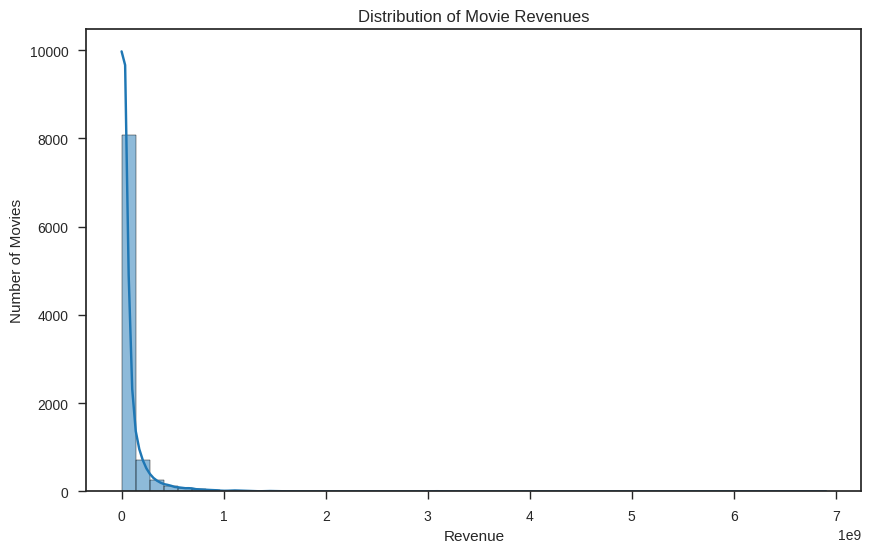

In [170]:
plt.figure(figsize=(10, 6))
sns.histplot(df_season["inflated_revenue"], bins=50, kde=True)
plt.title("Distribution of Movie Revenues")
plt.xlabel("Revenue")
plt.ylabel("Number of Movies")
plt.show()

Bar plot comparing the average revenue of movies released in different seasons

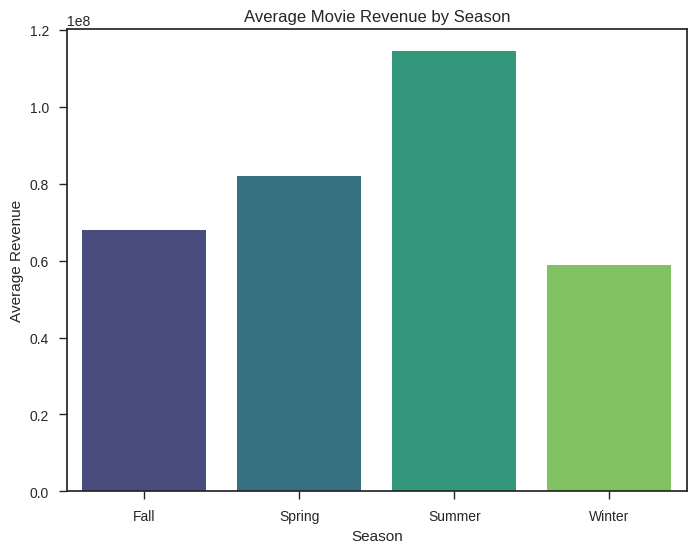

In [171]:
season_revenue = df_season.groupby("season")["inflated_revenue"].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x="season", y="inflated_revenue", data=season_revenue, palette="viridis")
plt.title("Average Movie Revenue by Season")
plt.xlabel("Season")
plt.ylabel("Average Revenue")
plt.show()

Scatter plot showing the relationship between movie duration and revenue, with points colored by season

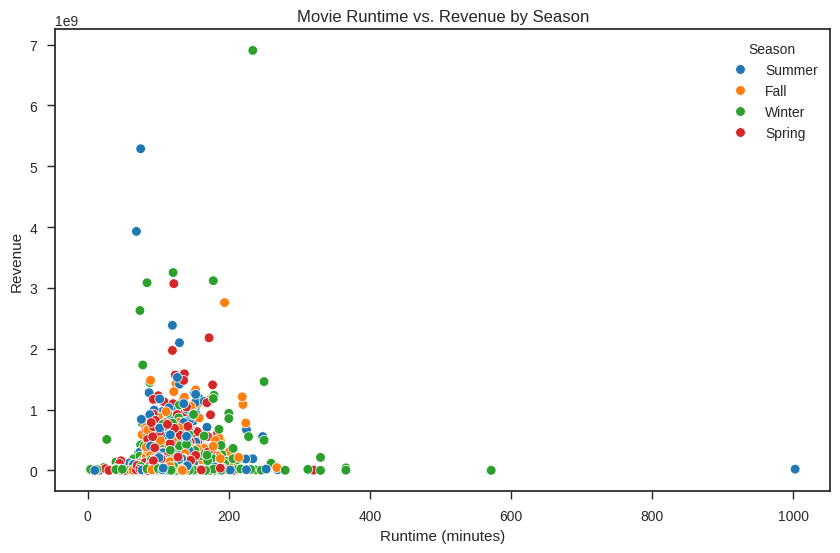

In [172]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="movie_runtime", y="inflated_revenue", hue="season", data=df_season)
plt.title("Movie Runtime vs. Revenue by Season")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue")
plt.legend(title="Season")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

#### Genre analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

</div>

Top 10 genres by revenue

In [173]:
# Convert the string representation to an actual list
df_genres_and_season = df_season.copy()

# First, ensure that the 'movie_genres' column is not null
df_genres_and_season = df_genres_and_season[
    df_genres_and_season["movie_genres"].notna()
]

# Apply ast.literal_eval to convert strings to lists
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    ast.literal_eval
)

# Now extract the genre names
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    lambda x: [genre[1] for genre in x]
)

# Explode the genres
df_genres_and_season = df_genres_and_season.explode("movie_genres")

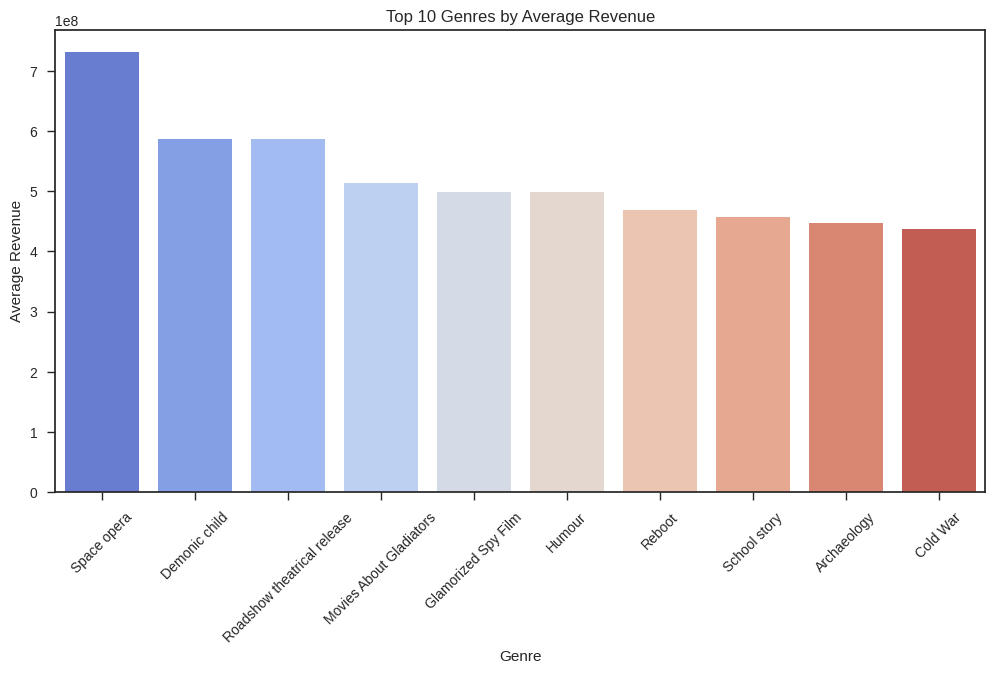

In [174]:
genre_revenue = (
    df_genres_and_season.groupby("movie_genres")["inflated_revenue"]
    .mean()
    .reset_index()
)
top_genres = genre_revenue.sort_values("inflated_revenue", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="movie_genres", y="inflated_revenue", data=top_genres, palette="coolwarm")
plt.title("Top 10 Genres by Average Revenue")
plt.xlabel("Genre")
plt.ylabel("Average Revenue")
plt.xticks(rotation=45)
plt.show()

Revenue based on season and genre

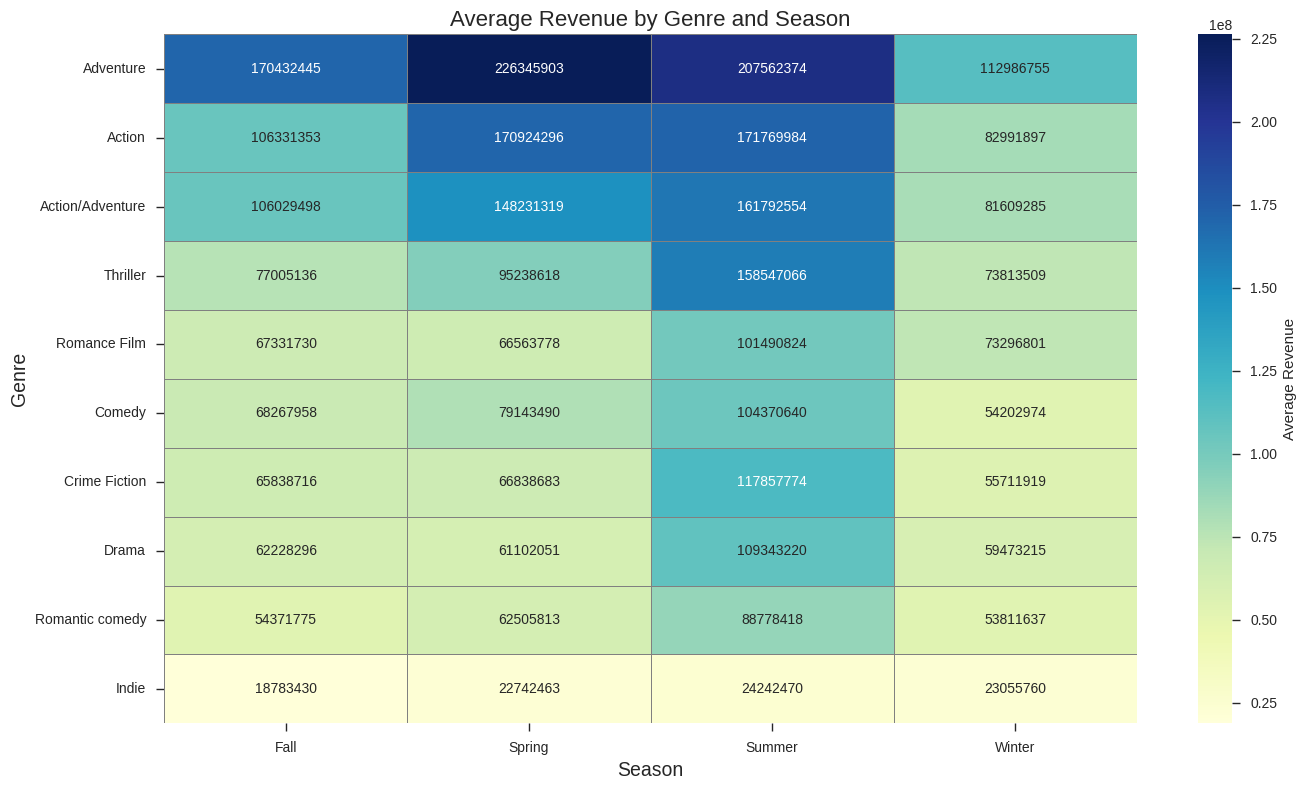

In [175]:
# Convert string representation to actual list
df_genres_and_season = df_season.copy()
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    ast.literal_eval
)
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    lambda x: [genre[1] for genre in x]
)
df_genres_and_season = df_genres_and_season.explode("movie_genres")

# Get top 10 genres by frequency
top_genres_list = (
    df_genres_and_season["movie_genres"].value_counts().head(10).index.tolist()
)
df_top_genres = df_genres_and_season[
    df_genres_and_season["movie_genres"].isin(top_genres_list)
]

pivot_table = df_top_genres.pivot_table(
    values="inflated_revenue",
    index="movie_genres",
    columns="season",
    aggfunc="mean",
)

# Calculate average revenue per genre
genre_revenue = (
    df_top_genres.groupby("movie_genres")["inflated_revenue"].mean().reset_index()
)
sorted_genres = genre_revenue.sort_values("inflated_revenue", ascending=False)[
    "movie_genres"
]

# Reorder the pivot table
pivot_table = pivot_table.reindex(index=sorted_genres)

plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Average Revenue"},
)
plt.title("Average Revenue by Genre and Season", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.yticks(rotation=0)  # Keep genre labels horizontal
plt.xticks(rotation=0)  # Keep season labels horizontal
plt.tight_layout()
plt.show()

Alternative representation 1

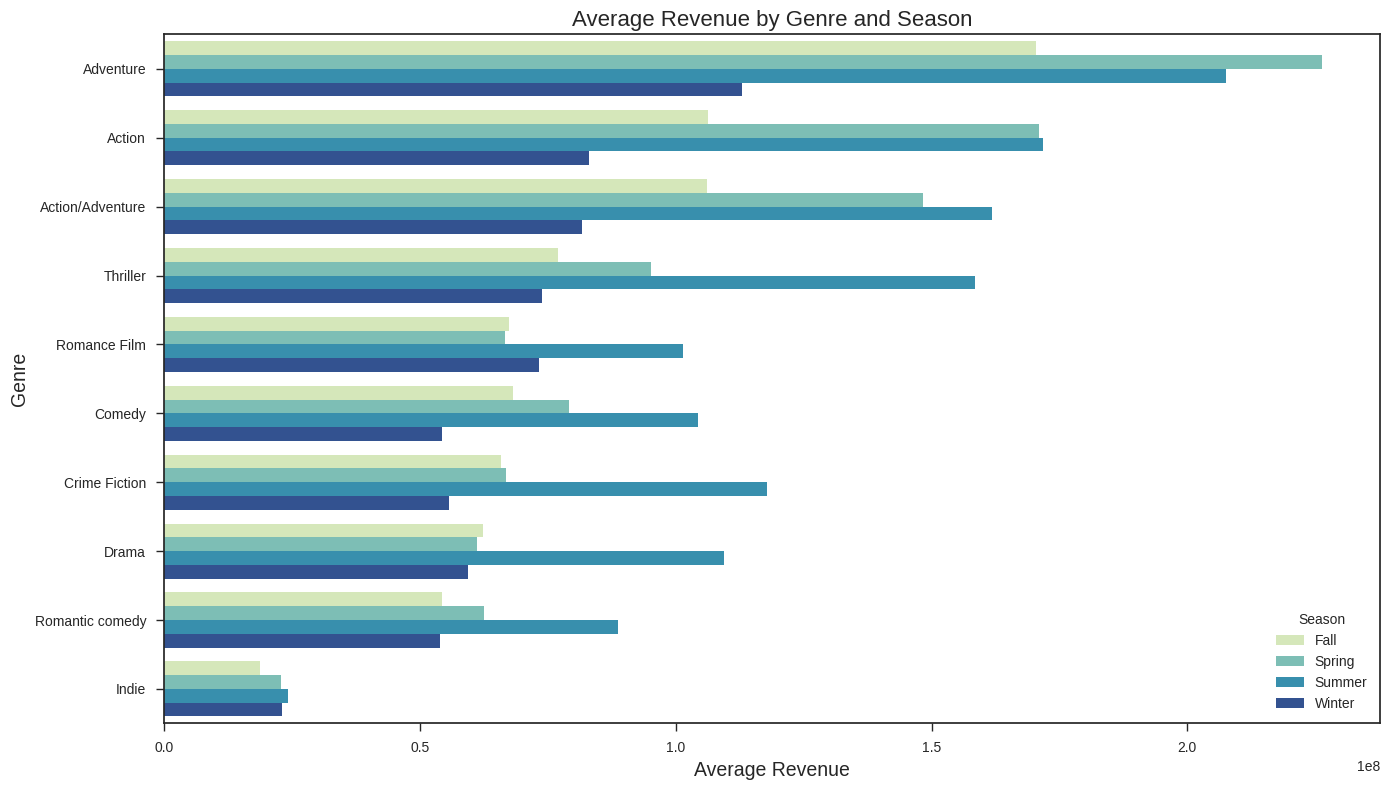

In [176]:
# Reset index for plotting
pivot_table_reset = pivot_table.reset_index().melt(
    id_vars="movie_genres", var_name="Season", value_name="Average Revenue"
)

plt.figure(figsize=(14, 8))
sns.barplot(
    x="Average Revenue",
    y="movie_genres",
    hue="Season",
    data=pivot_table_reset,
    palette="YlGnBu",
)
plt.title("Average Revenue by Genre and Season", fontsize=16)
plt.xlabel("Average Revenue", fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.legend(title="Season")
plt.tight_layout()
plt.show()

Alternative representation 2

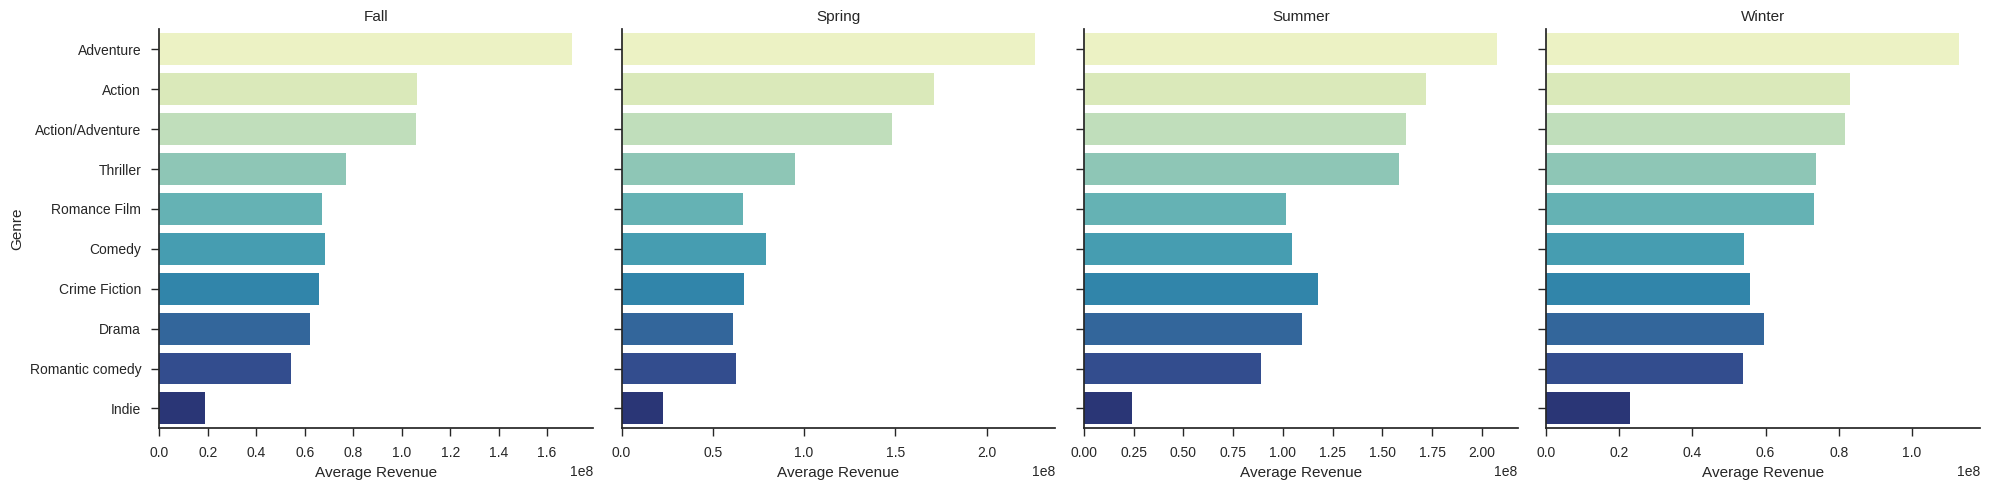

In [177]:
g = sns.FacetGrid(
    pivot_table_reset, col="Season", sharex=False, sharey=True, height=5, aspect=1
)
g.map_dataframe(
    sns.barplot,
    x="Average Revenue",
    y="movie_genres",
    order=sorted_genres,
    palette="YlGnBu",
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average Revenue", "Genre")
g.set(yticks=sorted_genres)
plt.tight_layout()
plt.show()

Alternative representation 3, disregarding thee frequency

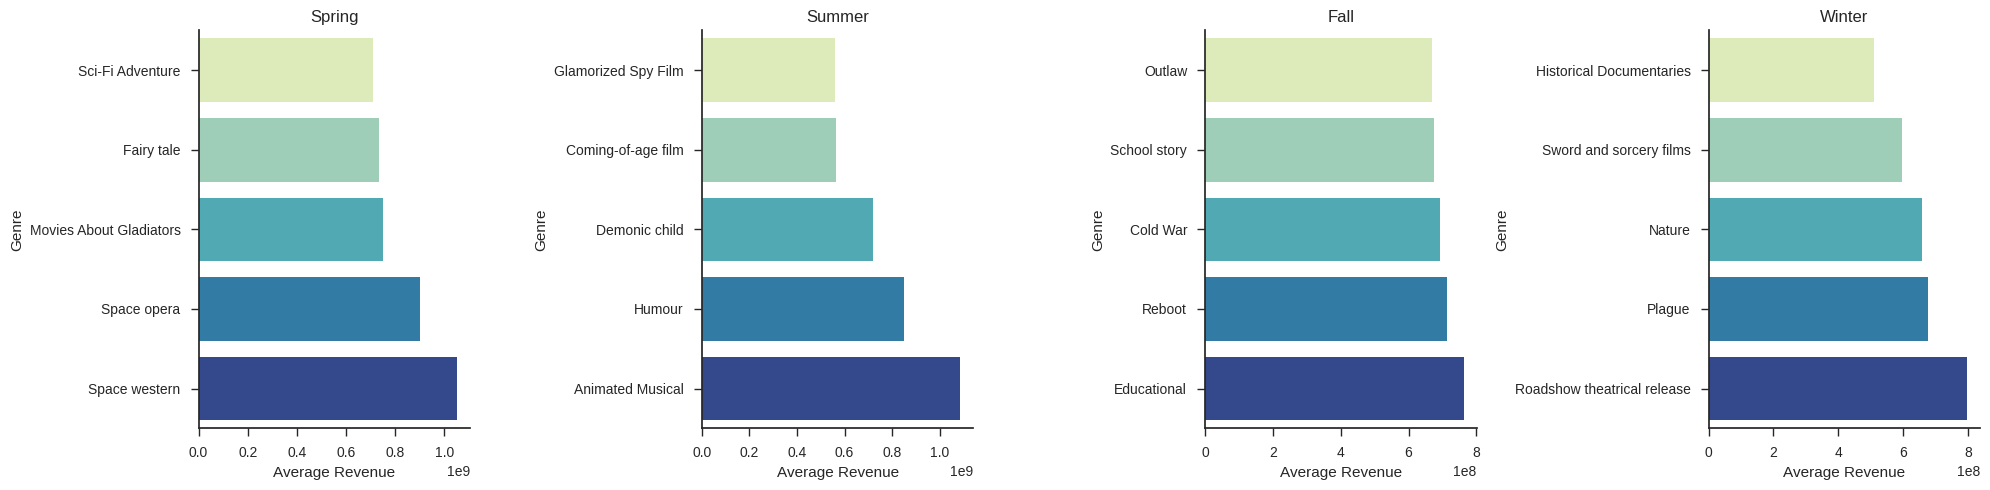

In [178]:
# Drop rows with missing values in 'season' or 'inflated_revenue'
df_genres_season = df_genres_and_season.dropna(subset=["season", "inflated_revenue"])

# Calculate average revenue per genre per season
genre_season_revenue = (
    df_genres_season.groupby(["season", "movie_genres"])["inflated_revenue"]
    .mean()
    .reset_index()
)

# Number of top genres to display per season
top_n = 5  # Adjust this number as needed

# Dictionary to store top genres per season
top_genres_per_season = {}

for season in genre_season_revenue["season"].unique():
    top_genres = (
        genre_season_revenue[genre_season_revenue["season"] == season]
        .sort_values("inflated_revenue", ascending=False)
        .head(top_n)["movie_genres"]
        .tolist()
    )
    top_genres_per_season[season] = top_genres

# Initialize an empty DataFrame to store filtered data
filtered_genre_season_revenue = pd.DataFrame()

# Loop through each season and filter the top genres
for season in top_genres_per_season:
    top_genres = top_genres_per_season[season]
    temp_df = genre_season_revenue[
        (genre_season_revenue["season"] == season)
        & (genre_season_revenue["movie_genres"].isin(top_genres))
    ]
    filtered_genre_season_revenue = pd.concat(
        [filtered_genre_season_revenue, temp_df], ignore_index=True
    )

# Rename columns for clarity
filtered_genre_season_revenue.rename(
    columns={
        "movie_genres": "Genre",
        "inflated_revenue": "Average Revenue",
        "season": "Season",
    },
    inplace=True,
)

# Set the order of seasons
season_order = ["Spring", "Summer", "Fall", "Winter"]

# Create the FacetGrid
g = sns.FacetGrid(
    filtered_genre_season_revenue,
    col="Season",
    col_order=season_order,
    sharex=False,
    sharey=False,
    height=5,
    aspect=1,
)

# Map the barplot onto the FacetGrid
g.map_dataframe(sns.barplot, x="Average Revenue", y="Genre", palette="YlGnBu")

# Adjust titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average Revenue", "Genre")

# Adjust y-ticks and sort data within each subplot
for ax, season in zip(g.axes.flat, season_order):
    # Get top genres for this season
    top_genres = top_genres_per_season.get(season, [])
    # Reverse the order for better visualization
    top_genres_reversed = list(reversed(top_genres))
    # Filter data for the current season
    data = filtered_genre_season_revenue[
        filtered_genre_season_revenue["Season"] == season
    ]
    # Sort data according to top genres
    data = data.set_index("Genre").loc[top_genres_reversed].reset_index()
    # Clear the axis and plot again
    ax.clear()
    sns.barplot(x="Average Revenue", y="Genre", data=data, palette="YlGnBu", ax=ax)
    ax.set_title(season)
    ax.set_xlabel("Average Revenue")
    ax.set_ylabel("Genre")

plt.tight_layout()
plt.show()

Revenue vs. Duration by Season

<Figure size 1000x600 with 0 Axes>

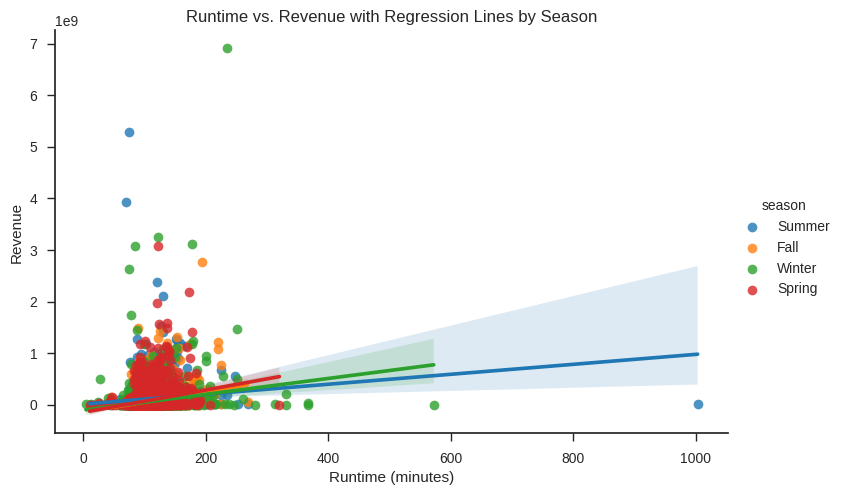

In [179]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    x="movie_runtime",
    y="inflated_revenue",
    hue="season",
    data=df_season,
    aspect=1.5,
)
plt.title("Runtime vs. Revenue with Regression Lines by Season")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue")
plt.show()

The scatter plot shows the relationship between the movie runtime and the box office revenue, where the movies are categorized by the season in which they were released.
Regression lines are added for each season, showing the trend or slope for each season’s data points. The lines indicate if there is a positive, negative, or negligible correlation between runtime and revenue for each season.

Positive Slope: Implies that movies with longer runtimes tend to generate higher revenue in that season.

Negative Slope: Suggests that shorter movies tend to have higher revenue in that season.

Flat or Near-Zero Slope: Indicates little to no relationship between runtime and revenue for that season.

Movie revenue by the day of the week

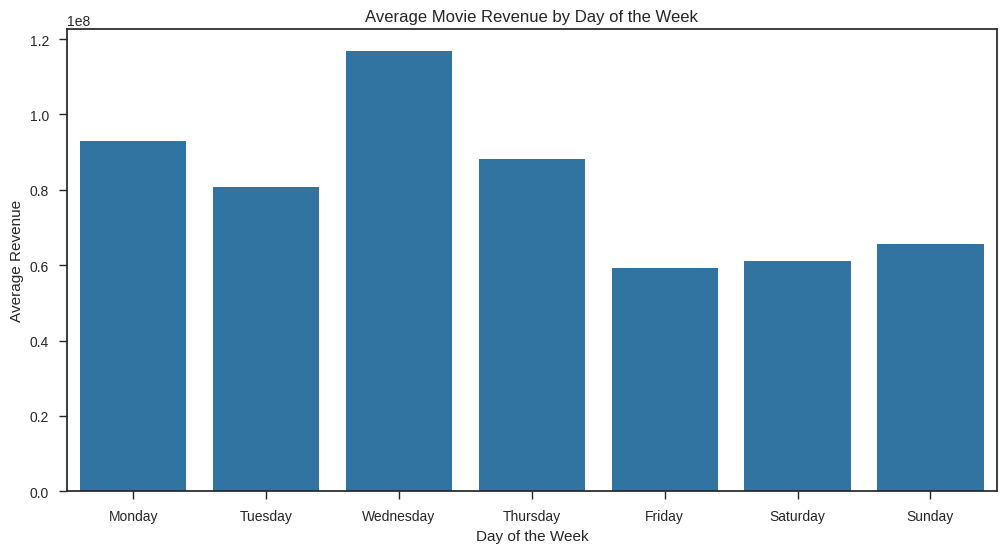

In [180]:
# Convert release date to datetime
df_season["movie_release_date"] = pd.to_datetime(
    df_season["movie_release_date"], errors="coerce"
)

# Extract day of the week
df_season["release_dayofweek"] = df_season["movie_release_date"].dt.day_name()

day_revenue = (
    df_season.groupby("release_dayofweek")["inflated_revenue"].mean().reset_index()
)
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

plt.figure(figsize=(12, 6))
sns.barplot(
    x="release_dayofweek",
    y="inflated_revenue",
    data=day_revenue,
    order=day_order,
)
plt.title("Average Movie Revenue by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Revenue")
plt.show()

Heatmap of Genre Frequency by Year

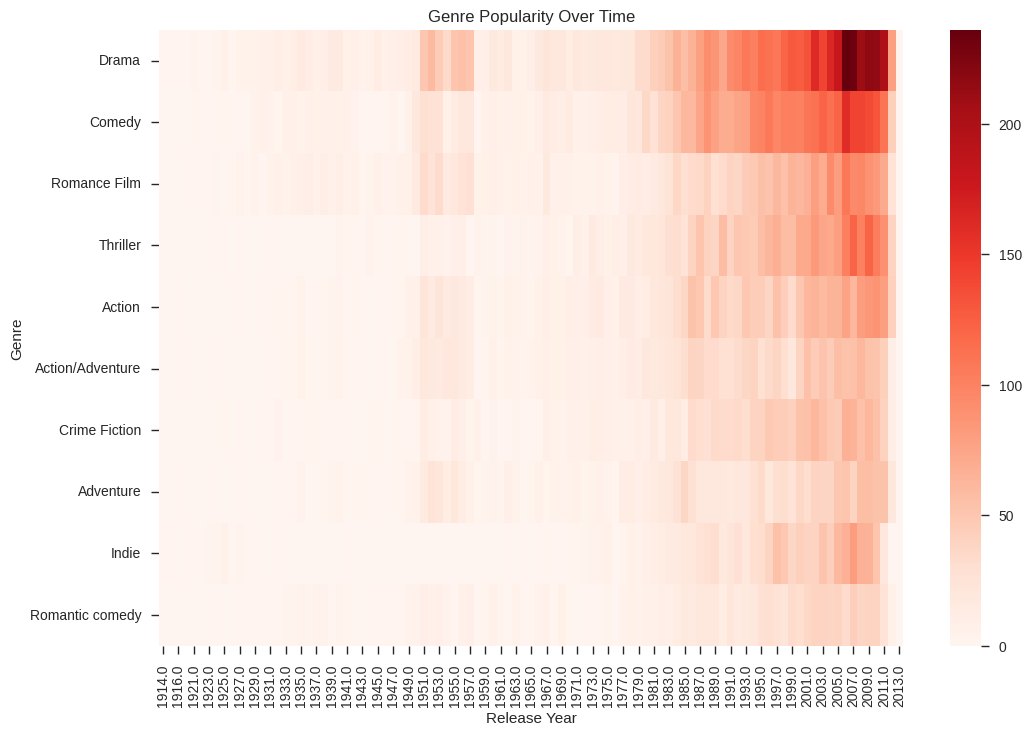

In [181]:
# Count of genres per year
genre_year = (
    df_genres_and_season.groupby(["movie_genres", "release_year"])
    .size()
    .reset_index(name="count")
)

# Pivot table
genre_year_pivot = genre_year.pivot_table(
    values="count", index="movie_genres", columns="release_year", fill_value=0
)

# Select top genres
top_genres_list = (
    df_genres_and_season["movie_genres"].value_counts().head(10).index.tolist()
)
genre_year_pivot = genre_year_pivot.loc[top_genres_list]

plt.figure(figsize=(12, 8))
sns.heatmap(genre_year_pivot, cmap="Reds")
plt.title("Genre Popularity Over Time")
plt.xlabel("Release Year")
plt.ylabel("Genre")
plt.show()

Genre popularity by season

/tmp/ipykernel_381043/2045569257.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
/tmp/ipykernel_381043/2045569257.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
/tmp/ipykernel_381043/2045569257.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
/tmp/ipykernel_381043/2045569257.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


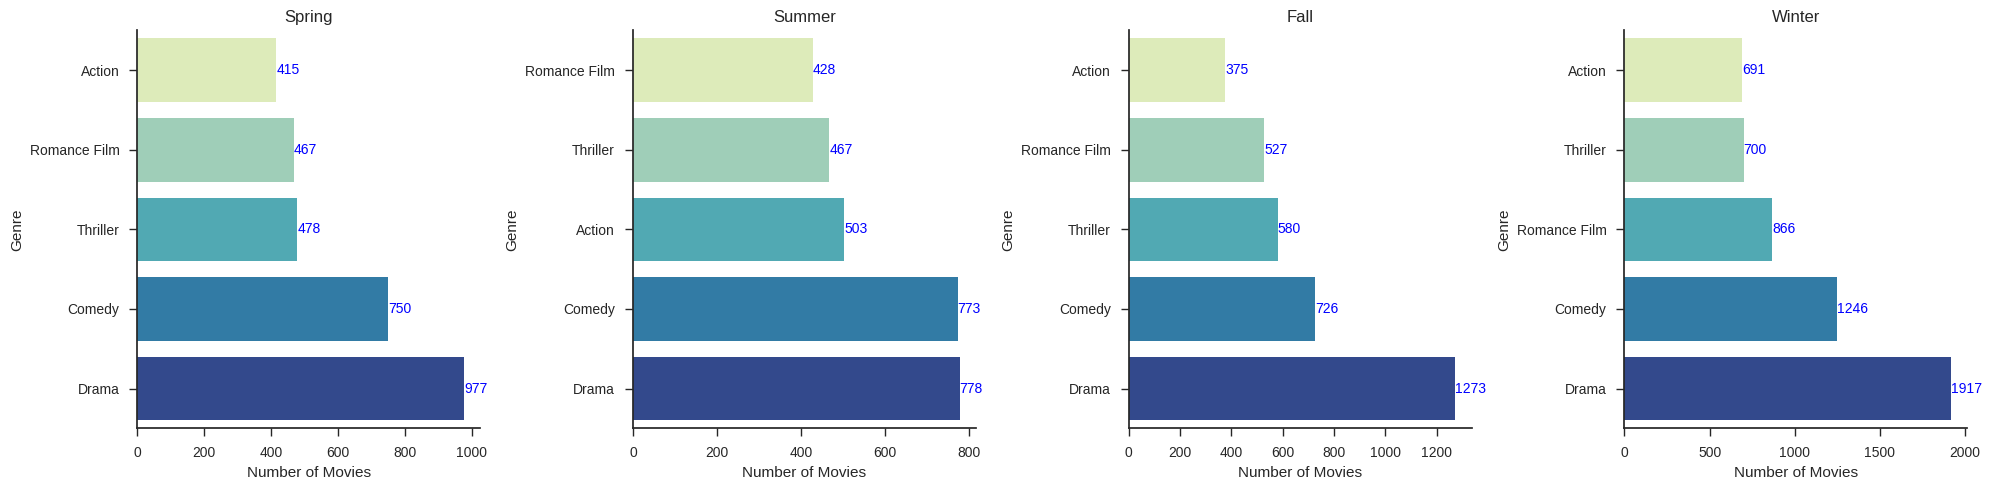

In [182]:
genre_season_count = (
    df_genres_and_season.groupby(["season", "movie_genres"])
    .size()
    .reset_index(name="movie_count")
)

# Number of top genres to display per season
top_n = 5  # Adjust this number as needed

# Dictionary to store top genres per season
top_genres_per_season = {}

for season in genre_season_count["season"].unique():
    top_genres = (
        genre_season_count[genre_season_count["season"] == season]
        .sort_values("movie_count", ascending=False)
        .head(top_n)["movie_genres"]
        .tolist()
    )
    top_genres_per_season[season] = top_genres


# Initialize an empty DataFrame to store filtered data
filtered_genre_season_count = pd.DataFrame()

# Loop through each season and filter the top genres
for season in top_genres_per_season:
    top_genres = top_genres_per_season[season]
    temp_df = genre_season_count[
        (genre_season_count["season"] == season)
        & (genre_season_count["movie_genres"].isin(top_genres))
    ]
    filtered_genre_season_count = pd.concat(
        [filtered_genre_season_count, temp_df], ignore_index=True
    )

# Rename columns for clarity
filtered_genre_season_count.rename(
    columns={"movie_genres": "Genre", "movie_count": "Movie Count", "season": "Season"},
    inplace=True,
)

# Set the order of seasons
season_order = ["Spring", "Summer", "Fall", "Winter"]

# Create the FacetGrid
g = sns.FacetGrid(
    filtered_genre_season_count,
    col="Season",
    col_order=season_order,
    sharex=False,
    sharey=False,
    height=5,
    aspect=1,
)

# Adjust y-ticks and plot data
for ax, season in zip(g.axes.flat, season_order):
    # Get data for the current season
    data = filtered_genre_season_count[filtered_genre_season_count["Season"] == season]
    # Get top genres and reverse for better visualization
    top_genres = list(reversed(top_genres_per_season.get(season, [])))
    # Sort data accordingly
    data = data.set_index("Genre").loc[top_genres].reset_index()
    # Plot
    sns.barplot(x="Movie Count", y="Genre", data=data, palette="YlGnBu", ax=ax)
    ax.set_title(season)
    ax.set_xlabel("Number of Movies")
    ax.set_ylabel("Genre")

    # Adjust y-ticks
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Display values on bars
    for i, v in enumerate(data["Movie Count"]):
        ax.text(v + 0.1, i, str(int(v)), color="blue", va="center")

plt.tight_layout()
plt.show()

Alternative representation

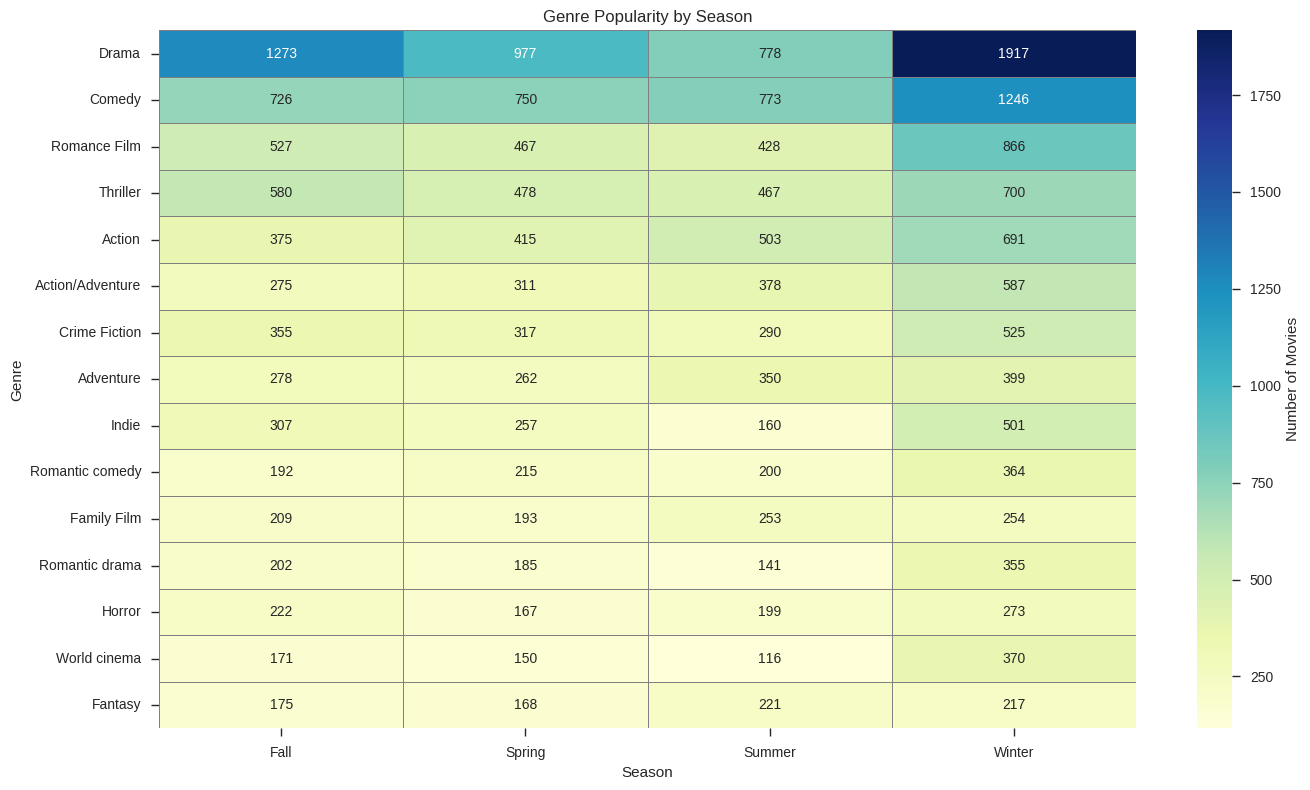

In [183]:
# Create pivot table
pivot_table = genre_season_count.pivot_table(
    values="movie_count",
    index="movie_genres",
    columns="season",
    aggfunc="sum",
    fill_value=0,
)

# Select top genres overall
top_genres_overall = (
    df_genres_and_season["movie_genres"].value_counts().head(15).index.tolist()
)
pivot_table = pivot_table.loc[top_genres_overall]

plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Number of Movies"},
)
plt.title("Genre Popularity by Season")
plt.xlabel("Season")
plt.ylabel("Genre")
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>

#### ANOVA for Seasons

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

</div>

In [184]:
# Convert the string representation to an actual list
df_season["movie_genres"] = df_season["movie_genres"].apply(ast.literal_eval)

# Extract genre names
df_season["movie_genres"] = df_season["movie_genres"].apply(
    lambda x: [genre[1] for genre in x]
)

# For simplicity, we'll focus on the primary genre (first in the list)
df_season["primary_genre"] = df_season["movie_genres"].apply(
    lambda x: x[0] if len(x) > 0 else np.nan
)

# Drop rows with missing primary genre
df_season = df_season.dropna(subset=["primary_genre"])

In [185]:
# Create a list of revenues for each season
season_revenues = [
    df_season[df_season["season"] == season]["inflated_revenue"]
    for season in df_season["season"].unique()
]

# Perform one-way ANOVA
F_statistic, p_value = f_oneway(*season_revenues)

print("ANOVA Results for Seasons:")
print("F-statistic:", F_statistic)
print("p-value:", p_value)

ANOVA Results for Seasons:
F-statistic: 34.0916292738672
p-value: 6.608581196787151e-22


With reduced complexity


ANOVA Results for Genres:
F-statistic: 25.716342276124497
p-value: 4.208199908675079e-21


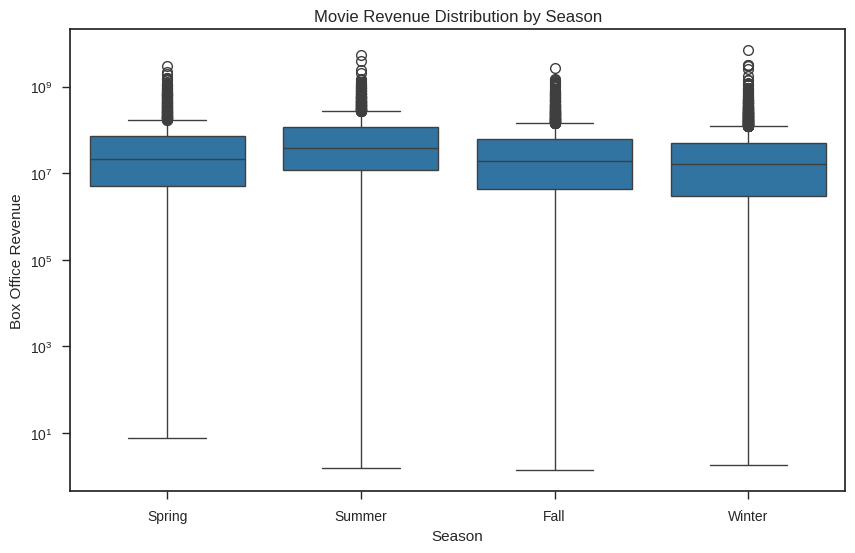

In [186]:
# Consider top N genres to reduce complexity
top_genres = df_season["primary_genre"].value_counts().head(5).index.tolist()
df_top_genres = df_season[df_season["primary_genre"].isin(top_genres)]

# Create a list of revenues for each genre
genre_revenues = [
    df_top_genres[df_top_genres["primary_genre"] == genre]["inflated_revenue"]
    for genre in top_genres
]

# Perform one-way ANOVA
F_statistic, p_value = f_oneway(*genre_revenues)

print("\nANOVA Results for Genres:")
print("F-statistic:", F_statistic)
print("p-value:", p_value)

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="season",
    y="inflated_revenue",
    data=df_season,
    order=["Spring", "Summer", "Fall", "Winter"],
)
plt.title("Movie Revenue Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Box Office Revenue")
plt.yscale("log")  # Use log scale if the revenue distribution is highly skewed
plt.show()

Boxplot of Revenue by Season

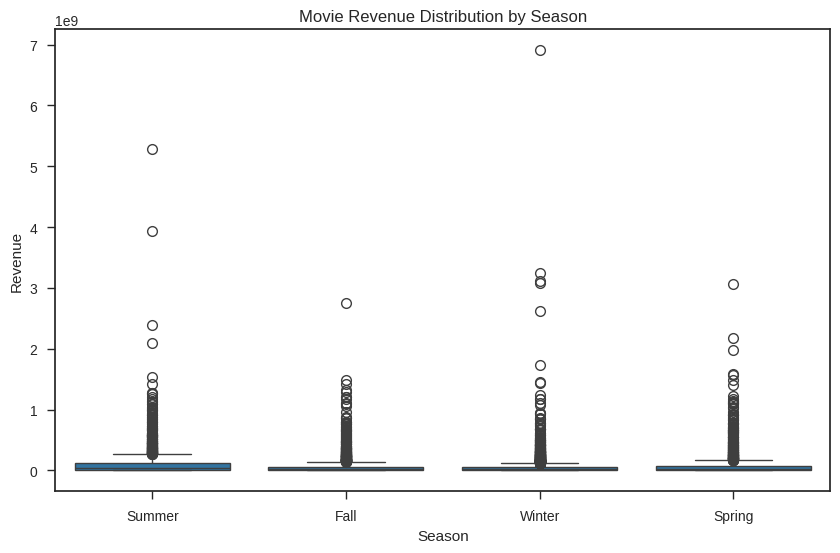

In [187]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="season", y="inflated_revenue", data=df_season)
plt.title("Movie Revenue Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Revenue")
plt.show()

Boxplot of Revenue by Genre

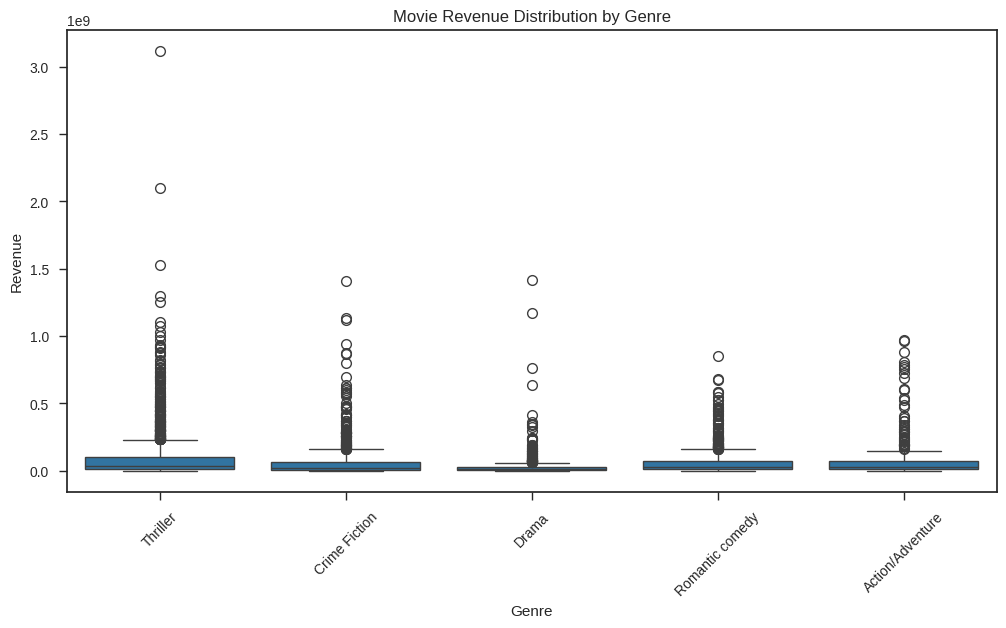

In [188]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="primary_genre", y="inflated_revenue", data=df_top_genres)
plt.title("Movie Revenue Distribution by Genre")
plt.xlabel("Genre")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>


</div>